# 0.0. IMPORTS

In [57]:
import psycopg2
import inflection
import requests
import pandas                  as pd
import seaborn                 as sns
import numpy                   as np
import scikitplot              as skplt
import matplotlib.pyplot       as plt
import boruta                  as bt
import xgboost                 as xgb
import random                  as rd
import pickle
import os

from sklearn.model_selection   import train_test_split, StratifiedKFold
from lightgbm                  import LGBMClassifier
from sklearn.naive_bayes       import GaussianNB
from psycopg2                  import Error
from sklearn.ensemble          import ExtraTreesClassifier, RandomForestRegressor
from tabulate                  import tabulate
from sklearn.preprocessing     import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.preprocessing     import StandardScaler
from sklearn.model_selection   import train_test_split
from IPython.display           import Image
from IPython.core.display      import HTML
from boruta                    import BorutaPy
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import StratifiedShuffleSplit as sss

from sklearn                   import metrics            as m
from sklearn                   import neighbors          as nh
from sklearn                   import ensemble           as en
from sklearn                   import model_selection    as ms
from scipy                     import stats              as ss

## 0.1. Helper Functions

In [7]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


# precision_at_k
def precision_at_k_(data, k):
    data = data.reset_index(drop=True)
    data['n_samples'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['n_samples']
    return data.loc[k, 'precision_at_k']

# recall_at_k
def recall_at_k_(data, k):
    data = data.reset_index(drop=True)
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    return data.loc[k, 'recall_at_k']


def model_results (model_ml, model_name, df, k ):
    
    precision_list = []
    recall_list = []
    
    #prediction
    yhat_proba_model = model_ml.predict_proba(x_validation)

    # copy dataframe
    df = x_validation.copy()
    df['response'] = y_validation.copy()

    # propensity score
    df['score'] = yhat_proba_model[:, 1].tolist()

    # sort clients by propensity score
    df = df.sort_values( 'score', ascending=False )

    # compute precision at k 
    precision_model = precision_at_k_( df, k )
    
    # compute recall at k
    recall_model = recall_at_k_( df, k )
    
    precision_list.append(precision_model)
    recall_list.append(recall_model)

    # plot
    fig, axs = plt.subplots(ncols= 2, figsize = (12,6));
    skplt.metrics.plot_cumulative_gain(Y_vali, yhat_proba_model, ax=axs[0],title='Cumulative Gain Curve');
    skplt.metrics.plot_lift_curve(Y_vali, yhat_proba_model,ax=axs[1],title='Lift Curve');
    
    # dataframe
    model_rank = pd.DataFrame(columns = {'Model':[], "Precision_at_k": [], "Recall_at_k": []})
    
    new_row = {'Model': model_name, 
               'Precision_at_k': precision_model,
               'Recall_at_k': recall_model}
            
    model_rank = model_rank.append(new_row, ignore_index = True)
    return model_rank

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()
####-------------------------------------------------------------------------------------------------------------------------------------------------------



def precision_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()      
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()  
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


def cross_validation(data, models_performance, num_folds, model_name, model, x_train, y_train, k):
    
    kfold = ms.StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)
    
    precision_list = []
    recall_list = []
    
    
    i=1
    for train_cv,val_cv in kfold.split(x_train, y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict_proba(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        
        precision = round(precision_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        precision_list.append(precision)
        
        recall = round(recall_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        recall_list.append(recall)
        
        
        
                
        i+=1
    
    precision_str = np.round(np.mean(precision_list), 3).astype(str) + ' +/- ' + np.round(np.std(precision_list), 3).astype(str)
    recall_str    = np.round(np.mean(recall_list), 3).astype(str)    + ' +/- ' + np.round(np.std(recall_list), 3)   .astype(str)
    models_performance = pd.DataFrame(columns = {'Model':[], "Precision_at_k": [], "Recall_at_k": []})
        
    models_performance = models_performance.append(pd.Series([model_name, precision_str, recall_str], index = models_performance.columns), ignore_index = True)

    return models_performance





Populating the interactive namespace from numpy and matplotlib


In [8]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [9]:
df_raw = pd.read_csv('C:/Users/leo_m/repos/health_insurance_by_leofaria/datasets/insurance_all_database.csv').reset_index(drop=True)

In [10]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,0,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,1,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,2,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,3,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,4,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [11]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [12]:
df1.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

## 1.2. Data Dimensions

In [13]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.3. Data Types

In [14]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,0,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,1,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,2,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,3,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,4,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


In [15]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [16]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5. Fillout NA

## 1.6. Change Data Types

## 1.7. Descriptive Statistics

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Atributes

In [18]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,381108.0,381108.0,190554.000000,190554.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.7.2. Categorical Atributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

In [21]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x== '> 2 Years' else 'between_1_2_year' if x== '1-2 Year'  else 'below_1_year')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [22]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas


## 3.2. Selecao das Colunas

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [23]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Age

<AxesSubplot:xlabel='response', ylabel='age'>

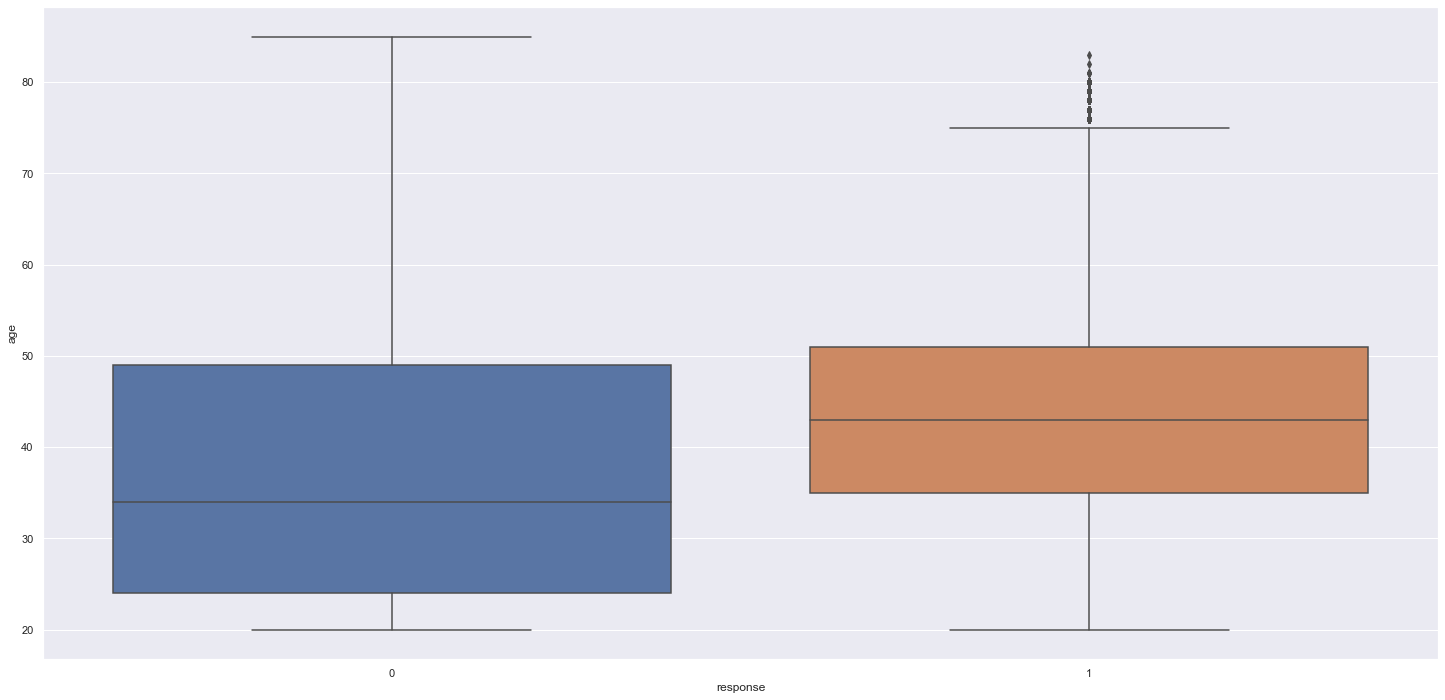

In [24]:
# age

sns.boxplot(x='response', y='age', data= df4)


<AxesSubplot:xlabel='age', ylabel='Count'>

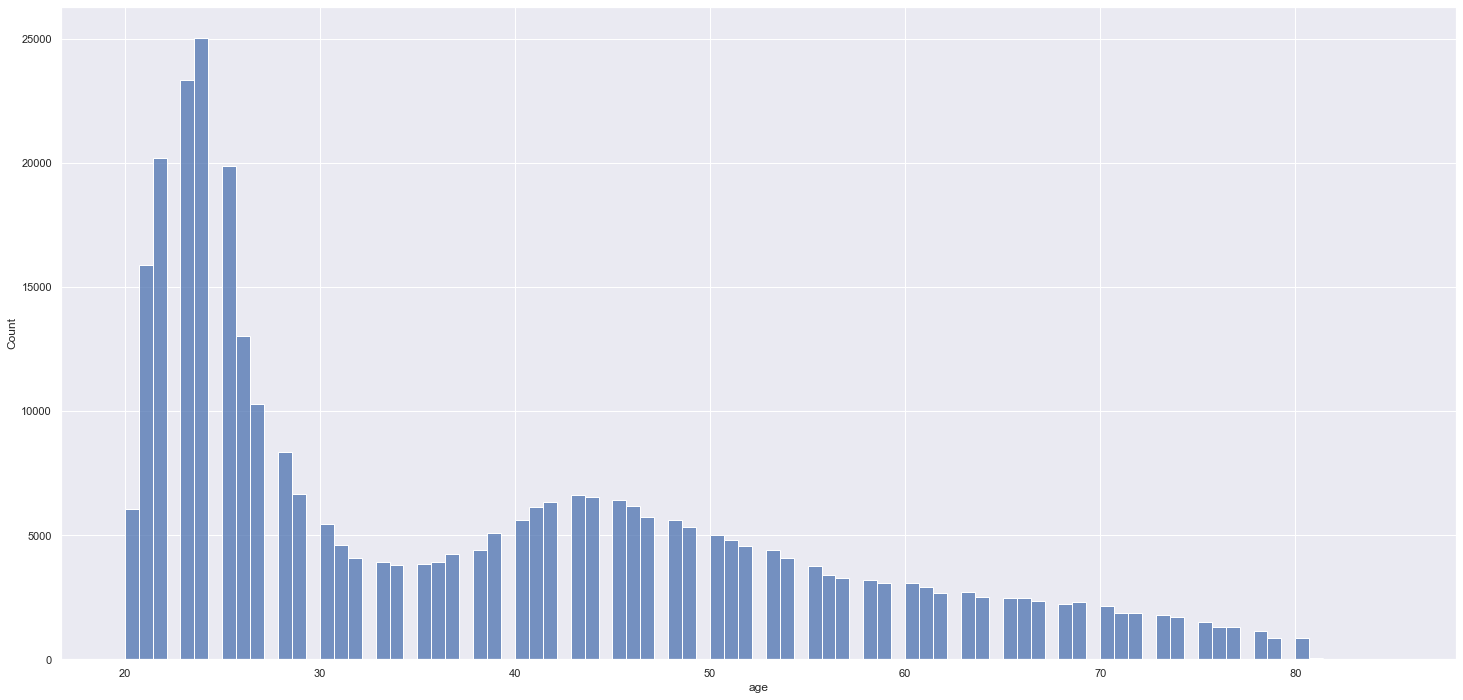

In [25]:
aux00 = df4.loc[df4['response'] == 0,'age']
sns.histplot( aux00)

<AxesSubplot:xlabel='age', ylabel='Count'>

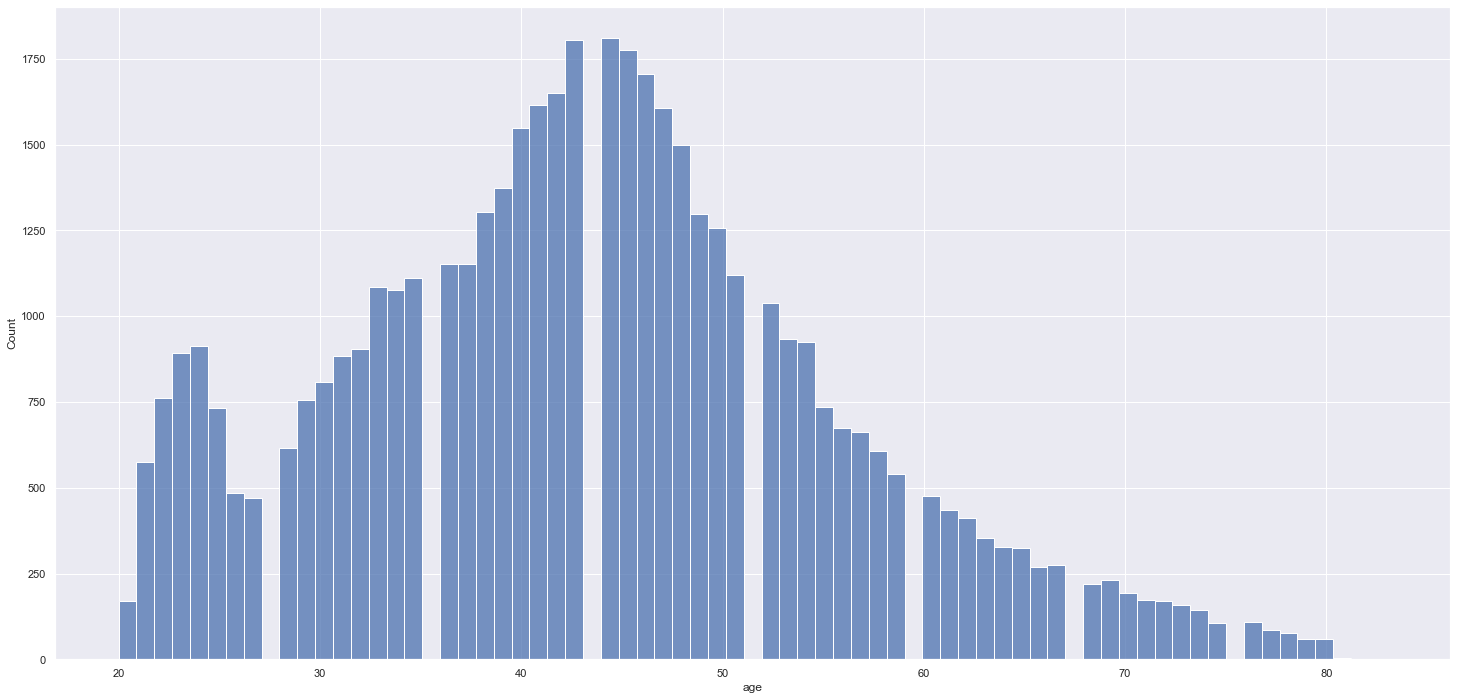

In [26]:
aux01 = df4.loc[df4['response'] == 1,'age']
sns.histplot( aux01)

### 4.1.2. Annual Premium

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

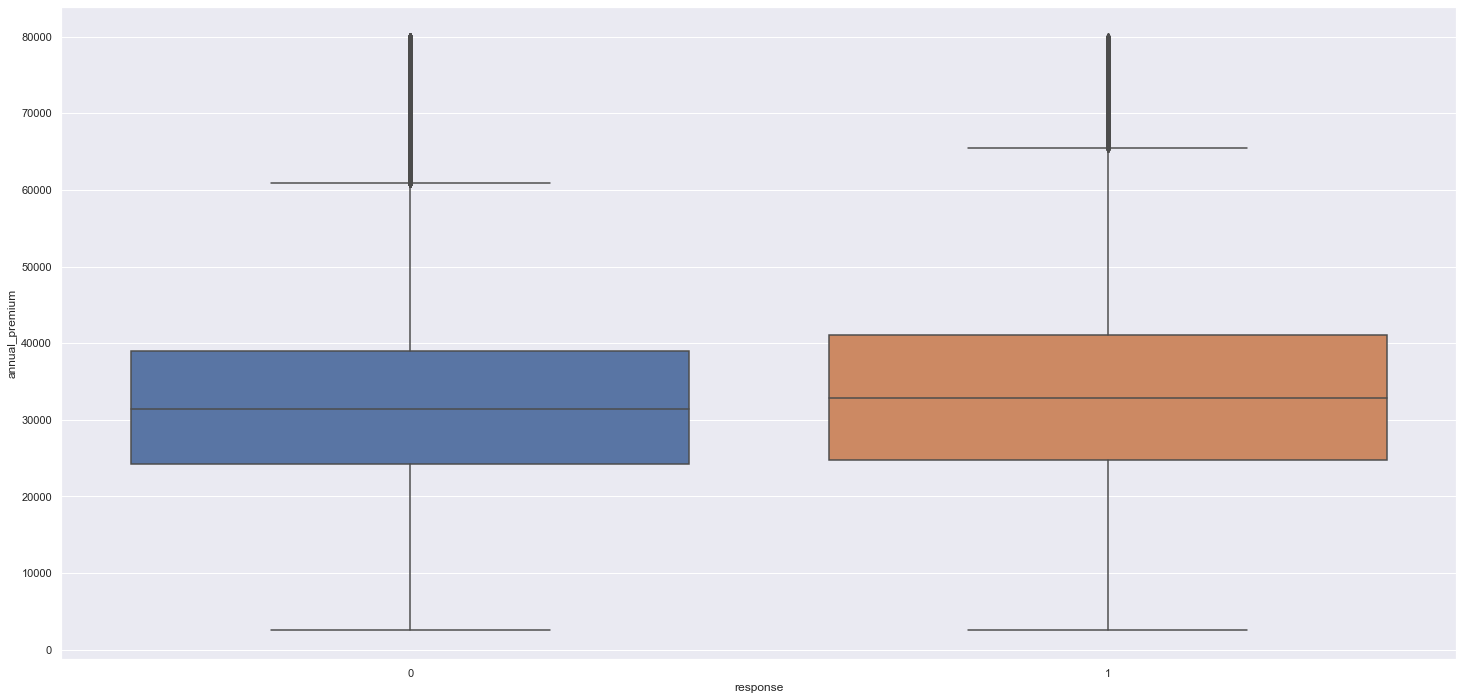

In [27]:
# annual_premium

aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data= aux)


<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

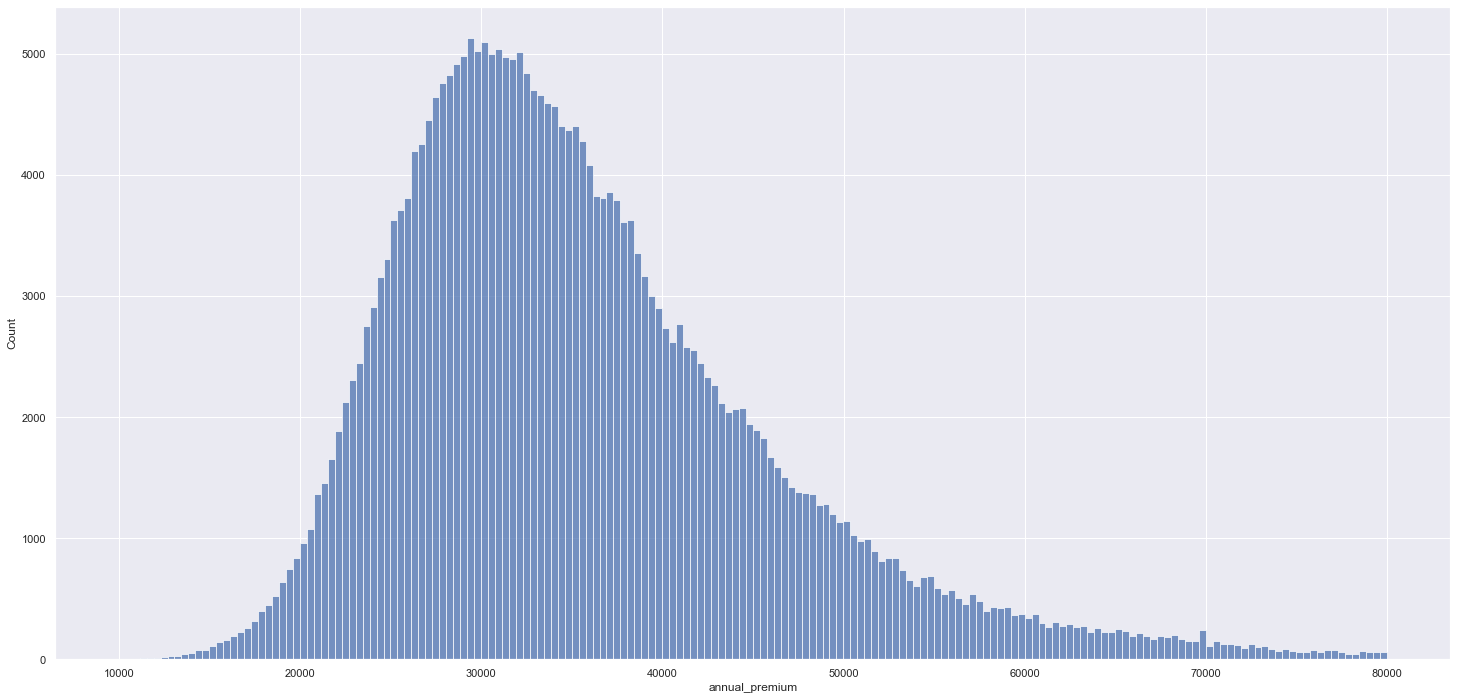

In [28]:
aux = df4[(df4['annual_premium'] >10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[aux['response'] == 0,'annual_premium']
sns.histplot( aux00)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

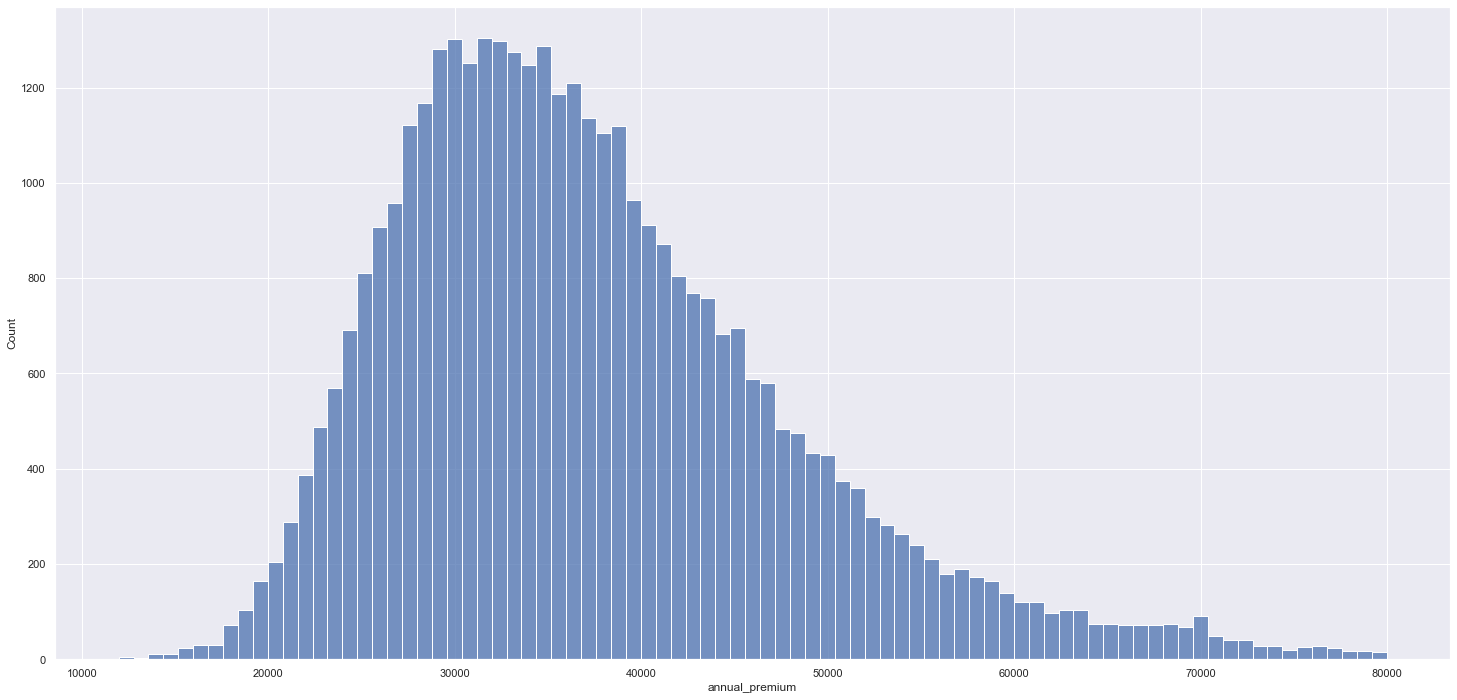

In [29]:
aux01 = aux.loc[aux['response'] == 1,'annual_premium']
sns.histplot( aux01)

### 4.1.3. Driving License

In [30]:
# driving_license

aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux
#sns.barplot( x='response', y= 'driving_license', data=aux )

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


### 4.1.4. Region Code

<AxesSubplot:xlabel='region_code', ylabel='id'>

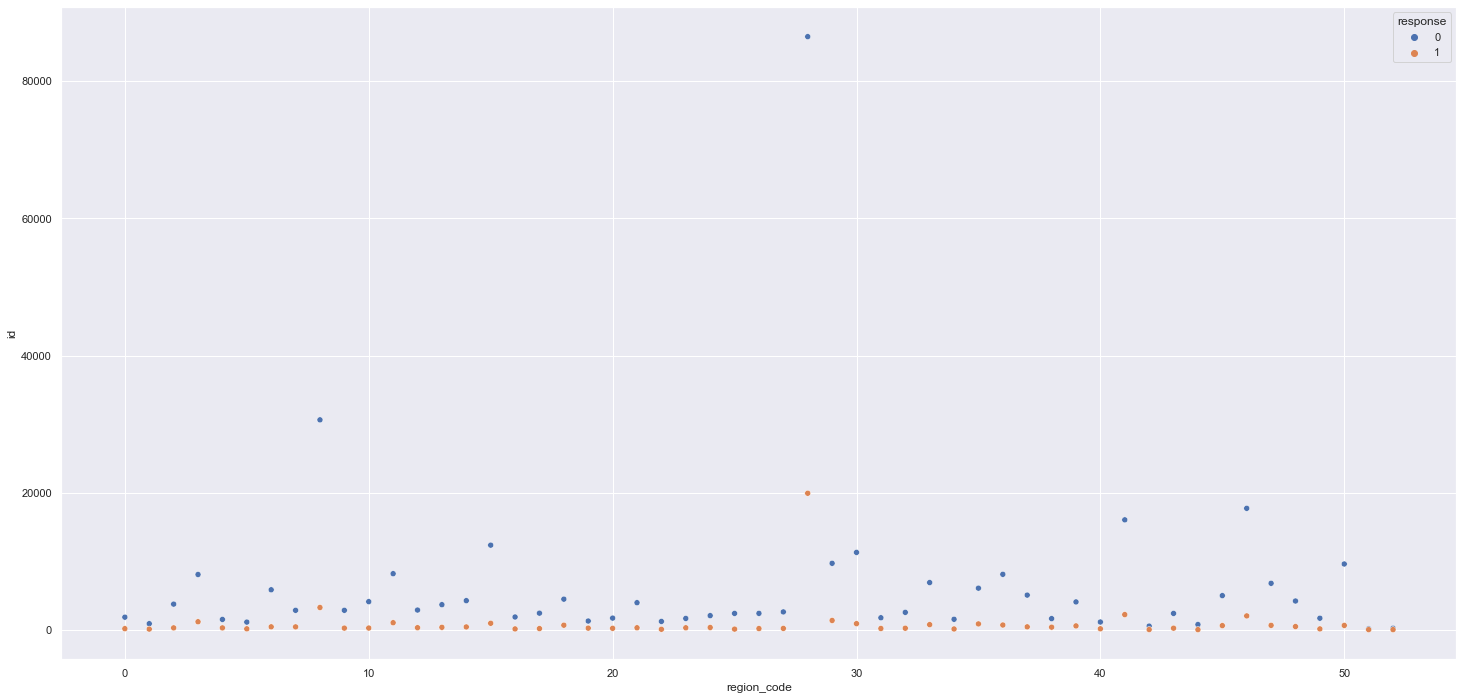

In [31]:
# region_code

aux0 = df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()
sns.scatterplot(x= 'region_code', y = 'id', hue='response', data=aux0)

### 4.1.5. Previously Insured

In [32]:
# previously_insured
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis = 1 )


response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 4.1.6. Vehicle Age

In [33]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()


,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


### 4.1.7. Policy Sales Channel

<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

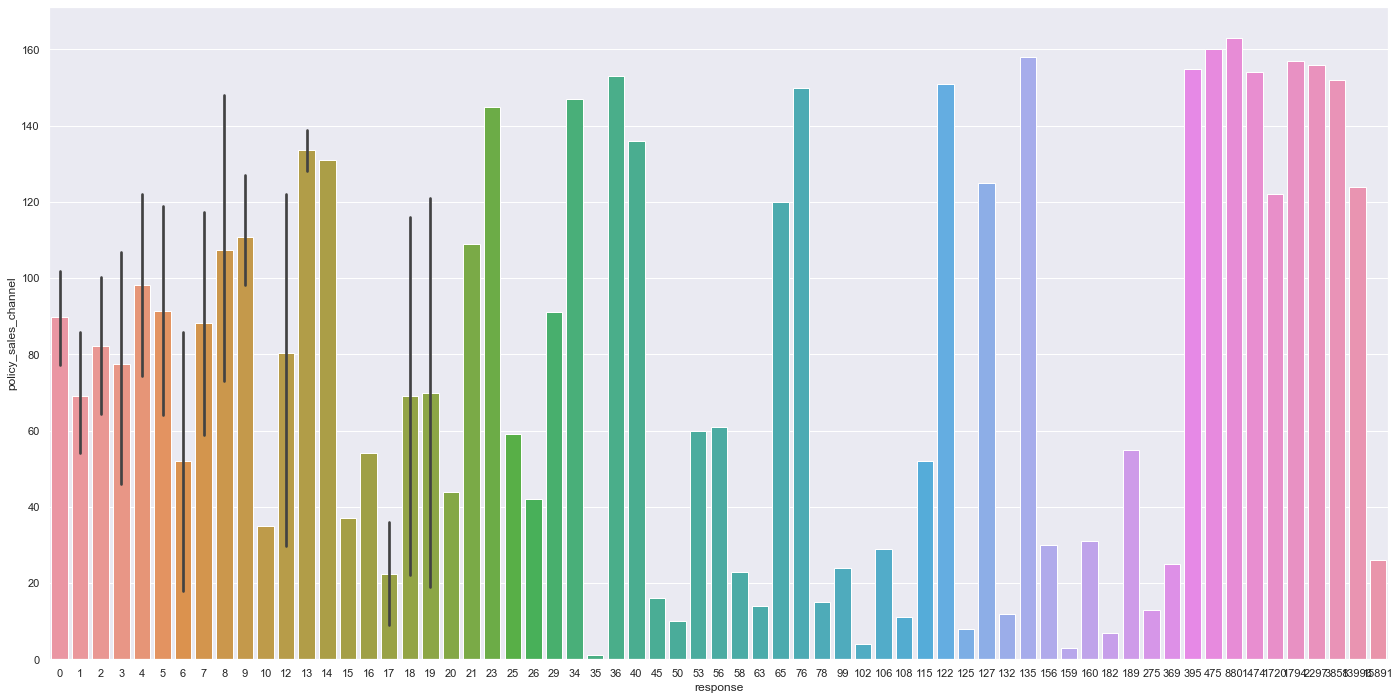

In [34]:
# policy_sales_channel
plt.figure( figsize=(24,12) )
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux )

### 4.1.8. Vintage

<AxesSubplot:xlabel='response', ylabel='vintage'>

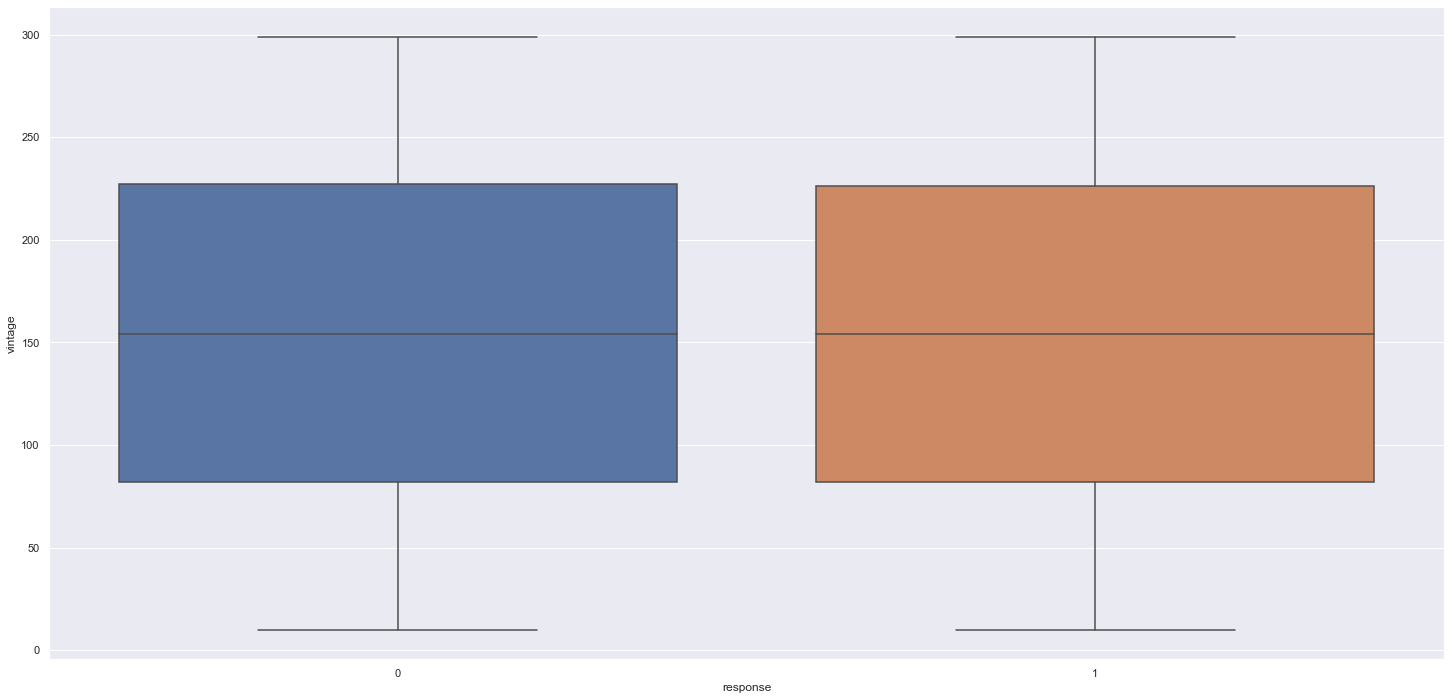

In [35]:
# vintage
sns.boxplot(x='response', y='vintage', data= df4)


<AxesSubplot:xlabel='vintage', ylabel='Count'>

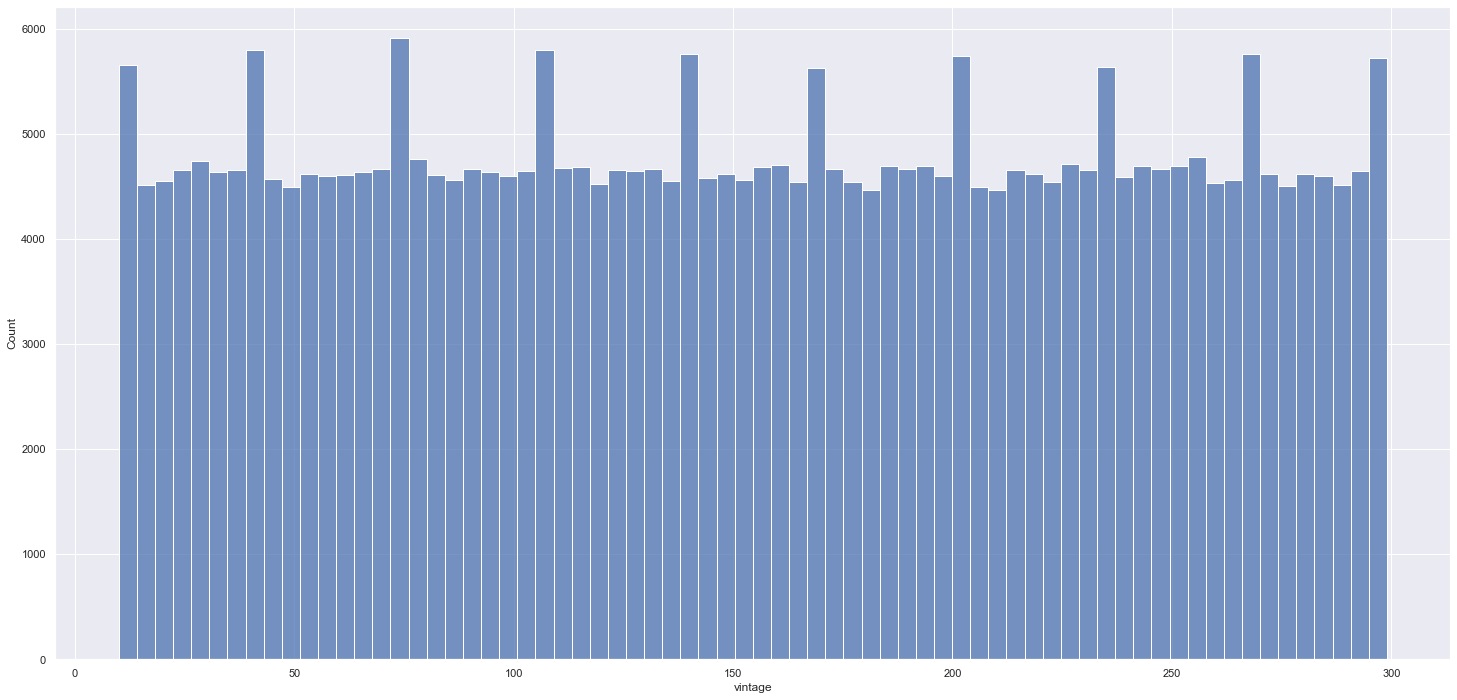

In [36]:
aux00 = df4.loc[df4['response'] == 0,'vintage']
sns.histplot( aux00)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

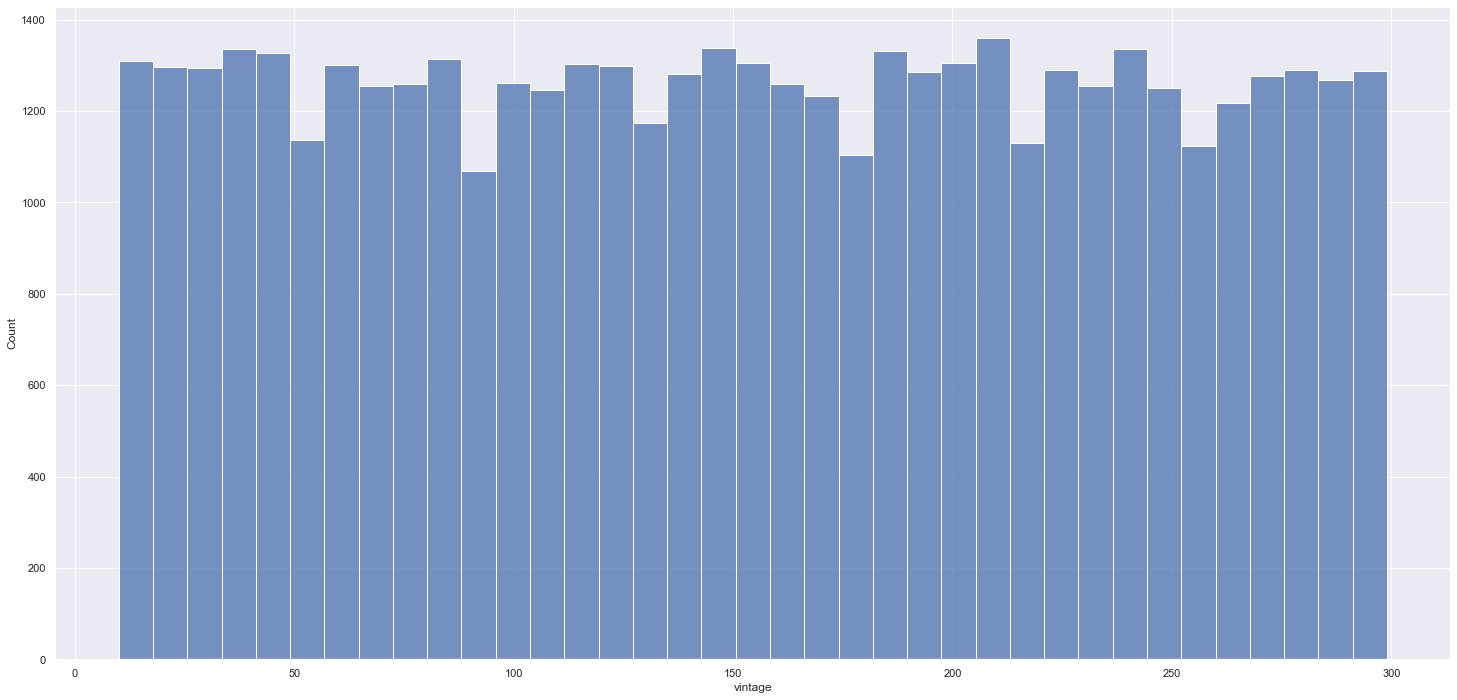

In [37]:
aux00 = df4.loc[df4['response'] == 1,'vintage']
sns.histplot( aux00)

### 4.1.9 Numerical Variables

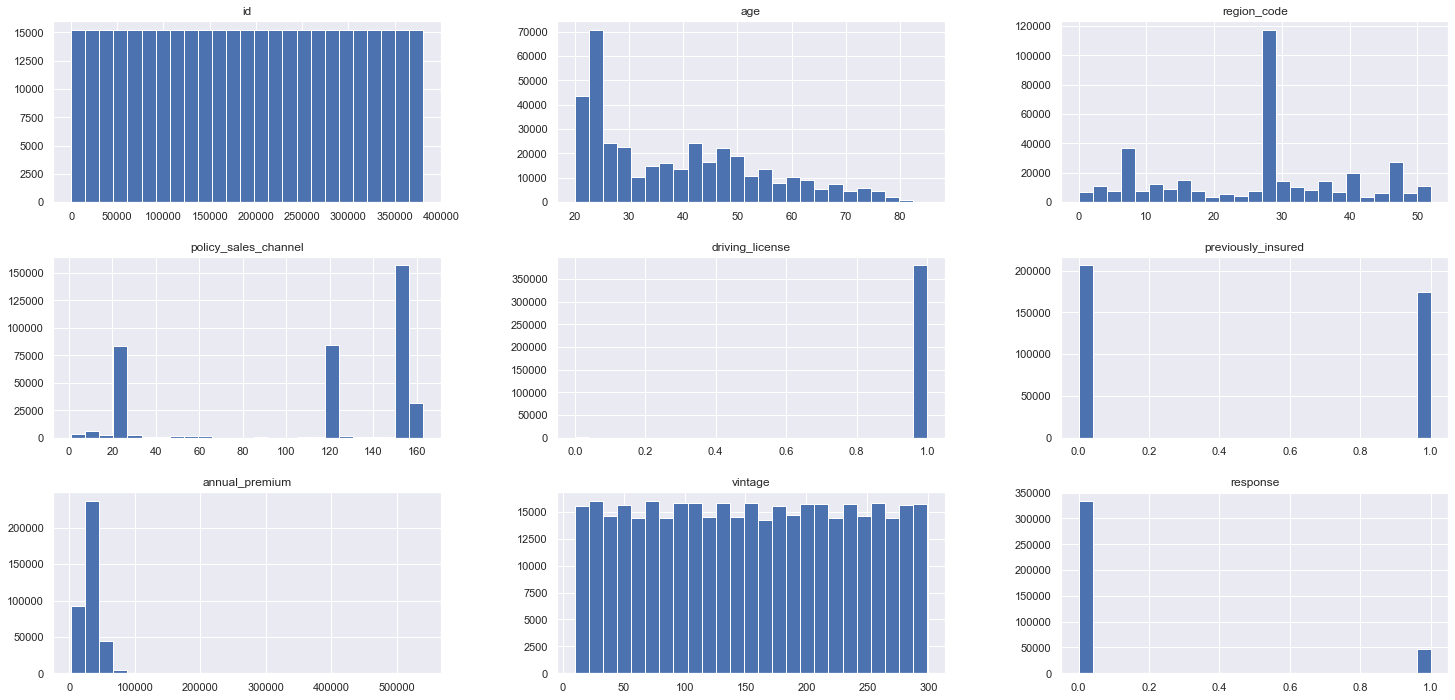

In [38]:
num_attributes.hist(bins=25);

### 4.1.10 Categorical Variables

In [39]:
cat_attributes.head()

,gender,vehicle_age,vehicle_damage
0,Male,< 1 Year,Yes
1,Female,1-2 Year,No
2,Female,< 1 Year,No
3,Female,< 1 Year,No
4,Male,1-2 Year,Yes


## 4.2 Analise Bivariada

### **H1.** Mulheres estão mais propensas a contratar seguros de carro.


**FALSE** Homens estão mais propensos a contratar seguros de carro

In [40]:
aux40 = df4[['id','gender','response']].groupby(['gender','response']).count().reset_index()
aux40.head()

,gender,response,id
0,Female,0,156835
1,Female,1,18185
2,Male,0,177564
3,Male,1,28525


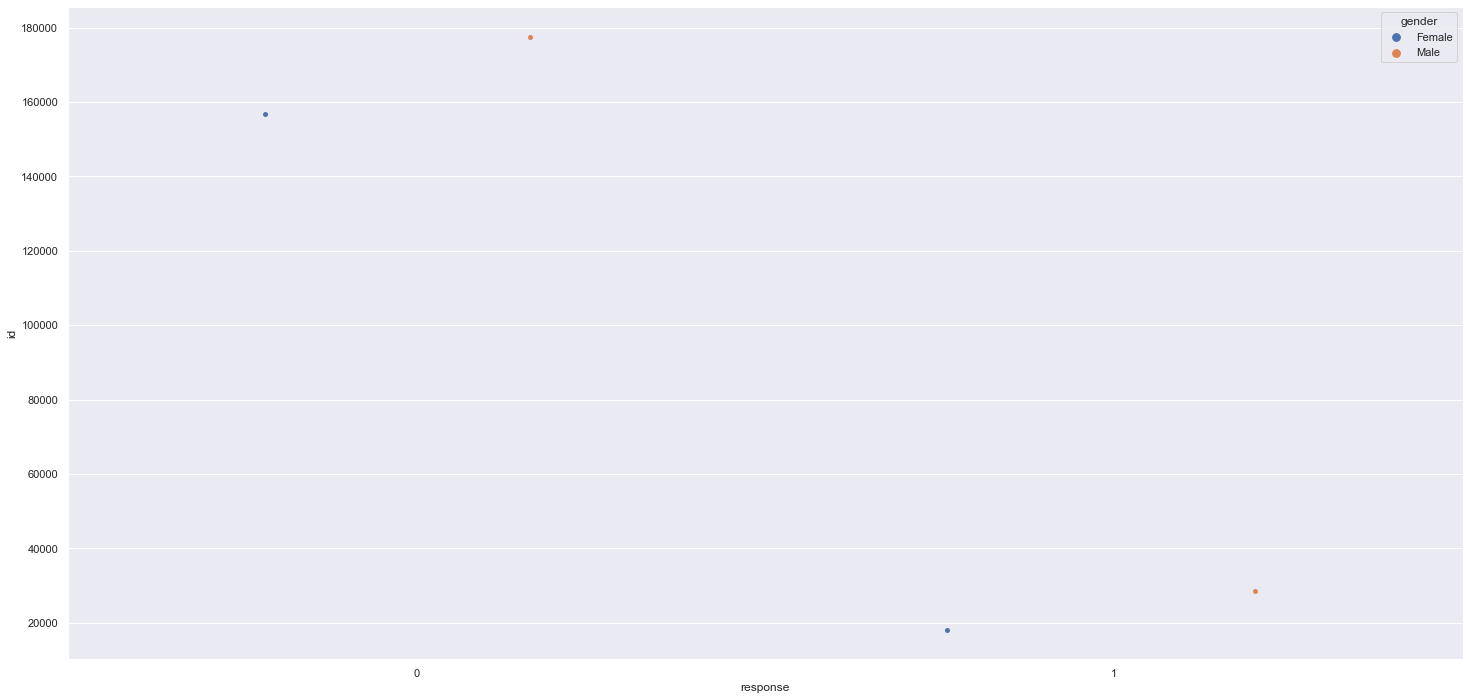

In [41]:
sns.stripplot(x='response', y='id', data=aux40, hue='gender', dodge=True);

### **H2.** A Faixa de Meia-idade tem maior a possibilidade de contratar um seguro de carro.


**TRUE** Meia-idade tem maior a possibilidade de contratar

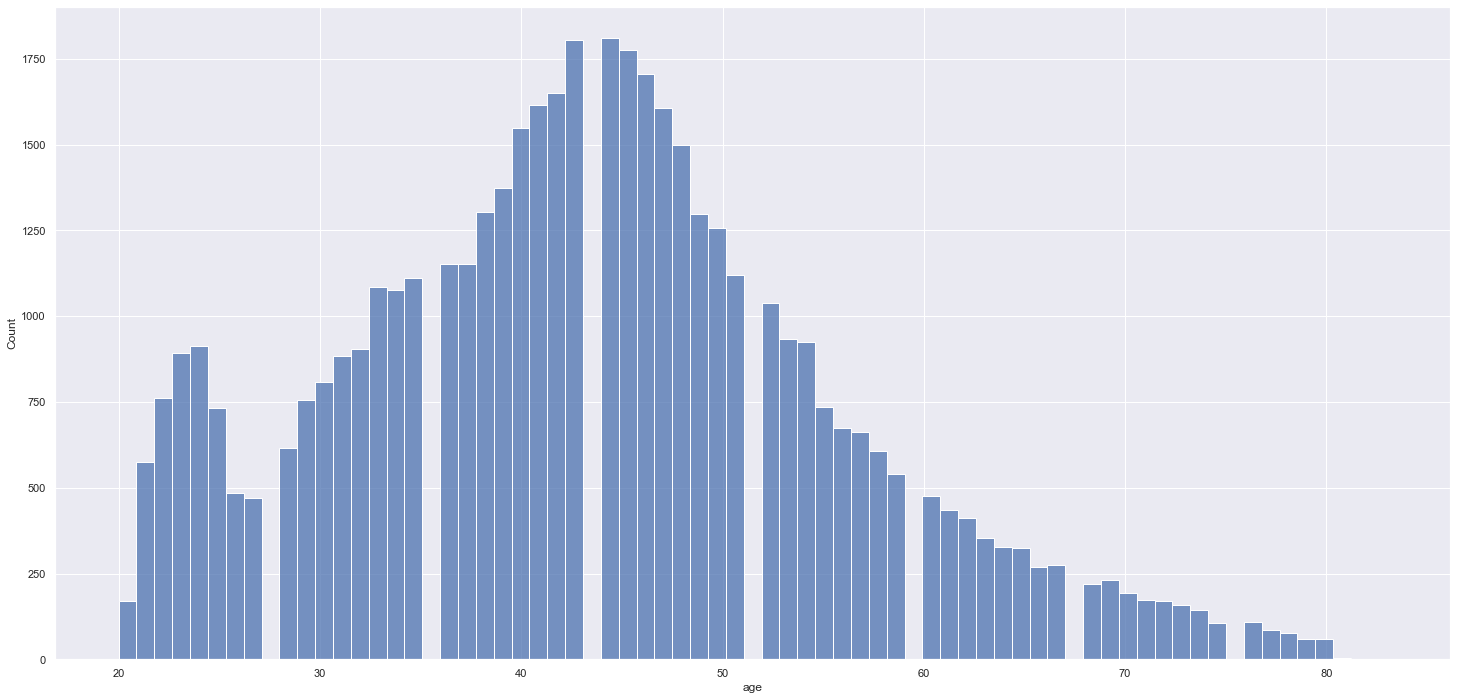

In [42]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 );

### **H3.** O local de residência influi na decisão de contratar um seguro de carro.


**TRUE** O local de residência influi

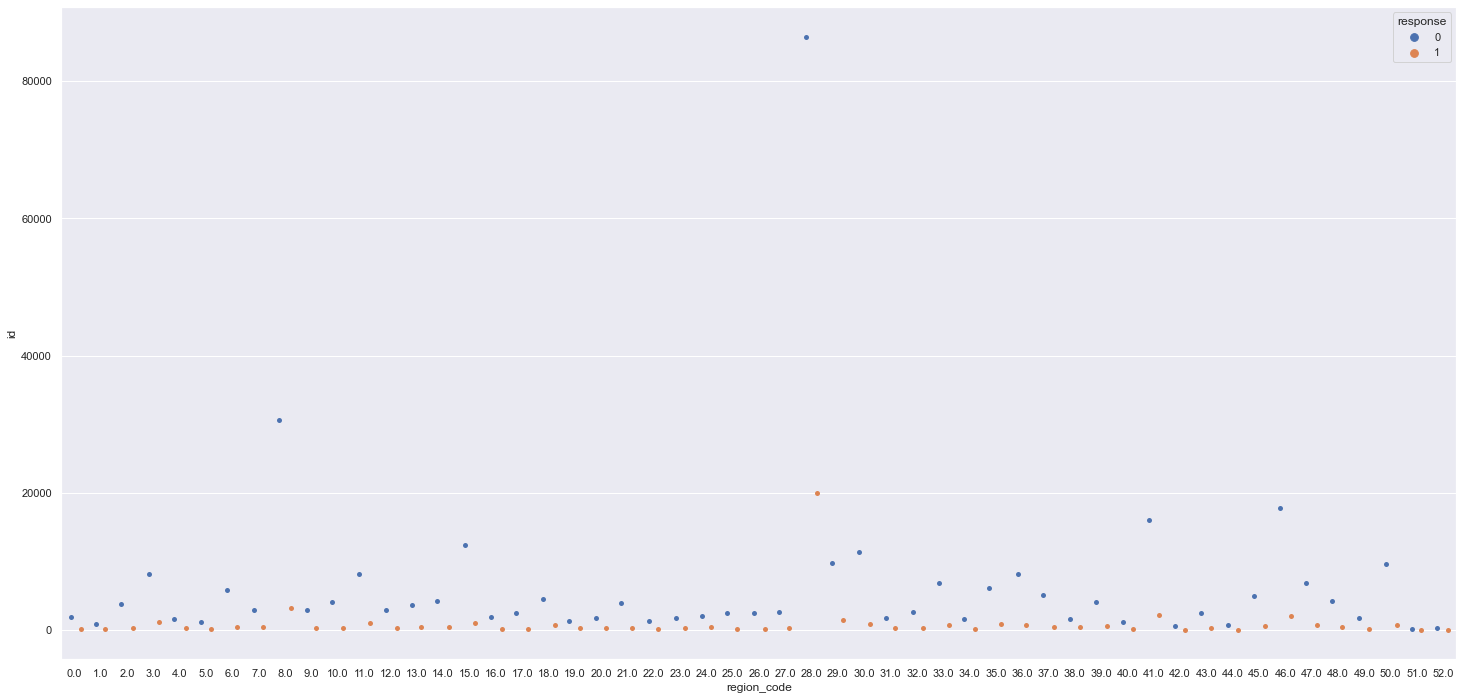

In [44]:
aux00= df4[['id', 'region_code','response']].groupby(['response','region_code']).count().reset_index()
sns.stripplot(x='region_code', y='id', data=aux00, hue='response', dodge=True);

### **H4.** Pessoas que já tiveram danos em seus carros tem maior propensão a contratar um seguro de carro.


**TRUE** Pessoas que já tiveram danos em seus carros TENDEM  a contratar

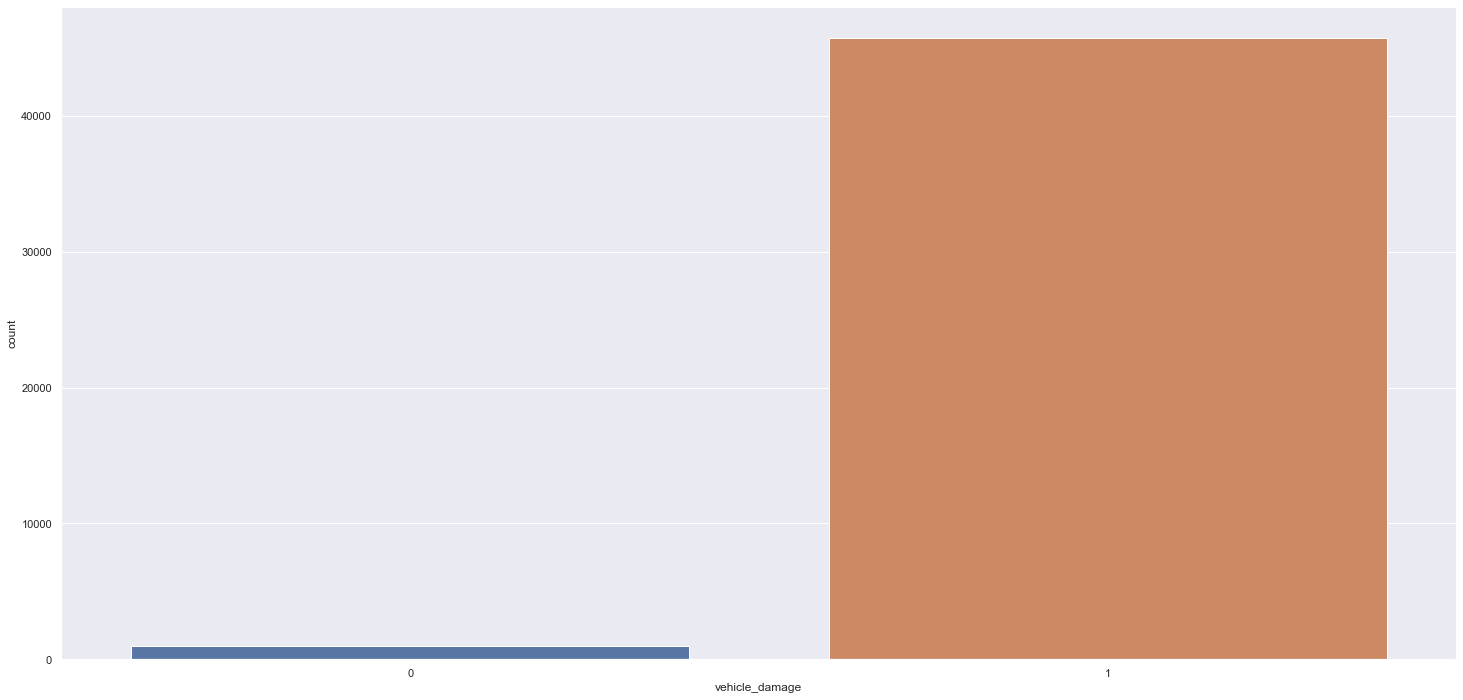

In [45]:
aux = df4[df4['response'] == 1]
sns.countplot(data = aux, x = 'vehicle_damage');

### **H5.** Pessoas que a já possuem seguro de carro tem maior propensão a adquirir uma nova apólice.


**FALSE** Pessoas que a já possuem seguro nao querem uma nova apolice

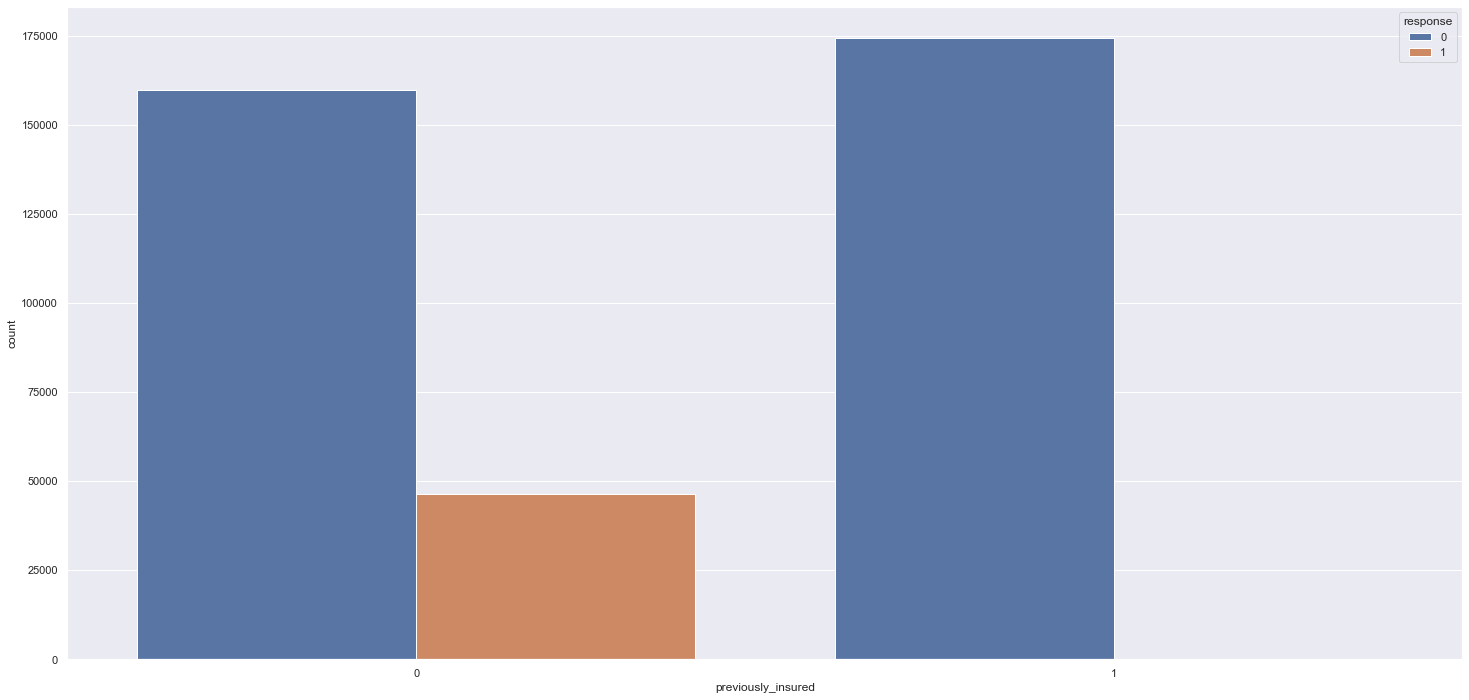

In [46]:
sns.countplot(data = df4, x = 'previously_insured', hue = 'response');

### **H6.** Pessoas com veículos mais novos tem maior tendência a contratar seguro de carro.


**FALSE** Pessoas com veículos ENTRE 1 E 2 ANOS tendem a contratar

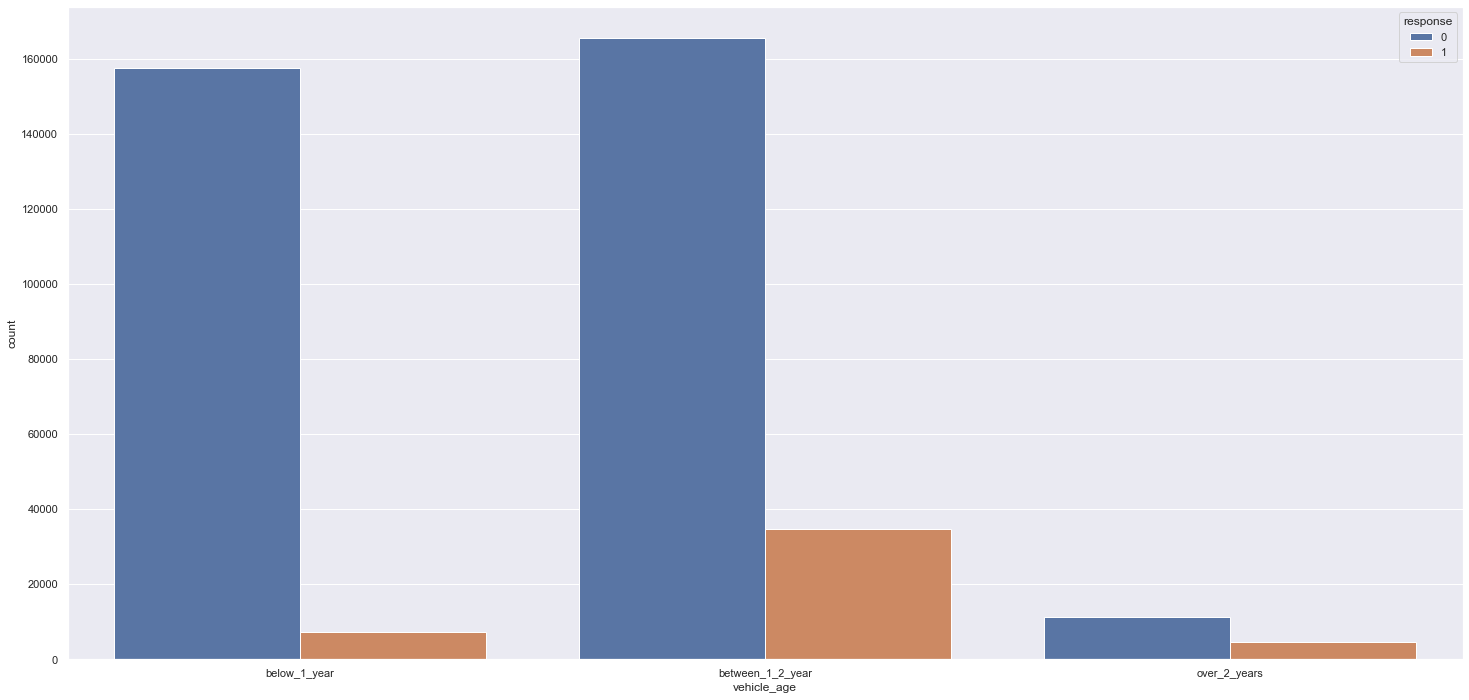

In [47]:
sns.countplot(data = df4, x = 'vehicle_age', hue = 'response');

### **H7.** Clientes com relação mais antiga com a seguradora tem maior propensão em contratar um novo produto.


**FALSE** O numero se mantem na media

<AxesSubplot:xlabel='vintage', ylabel='Count'>

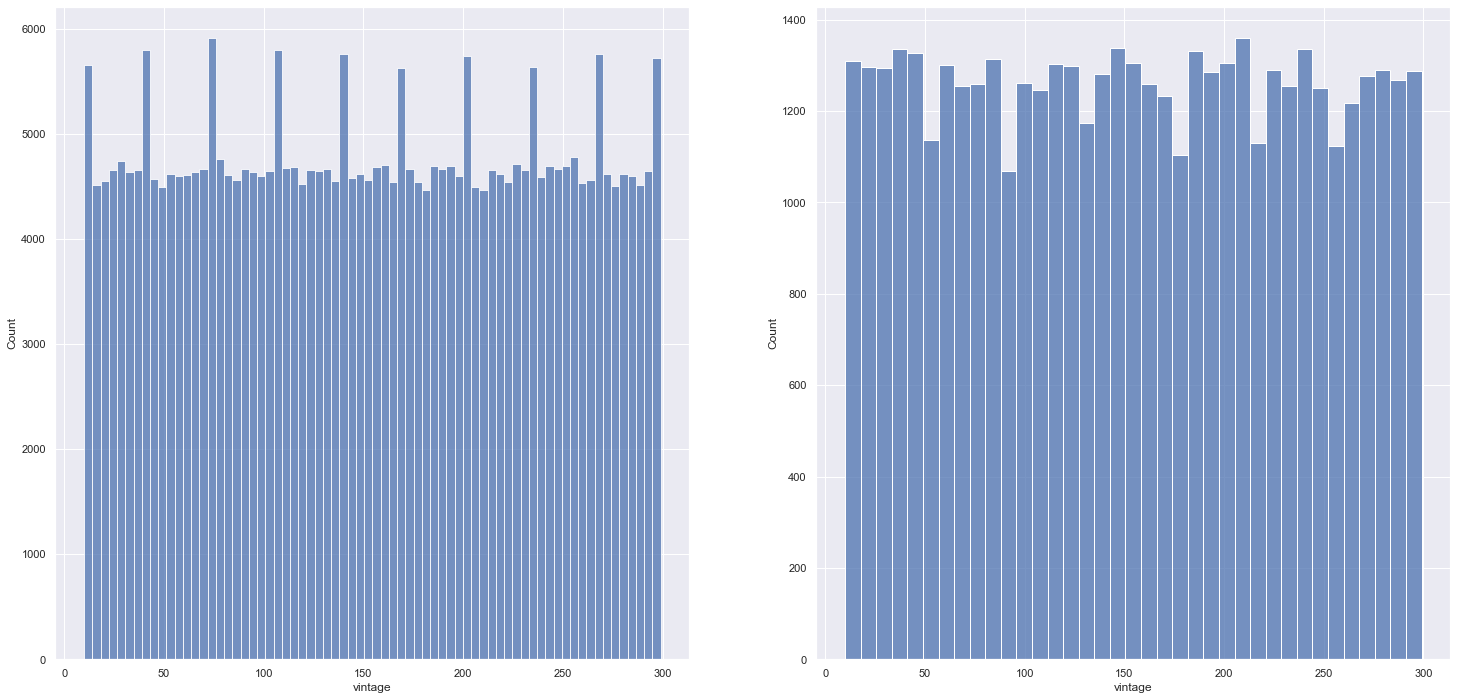

In [48]:
aux1 = df4.loc[df4['response'] == 0, 'vintage']
plt.subplot (1,2,1)
sns.histplot( aux1 )

aux2 = df4.loc[df4['response'] == 1, 'vintage']
plt.subplot (1,2,2)
sns.histplot( aux2 )

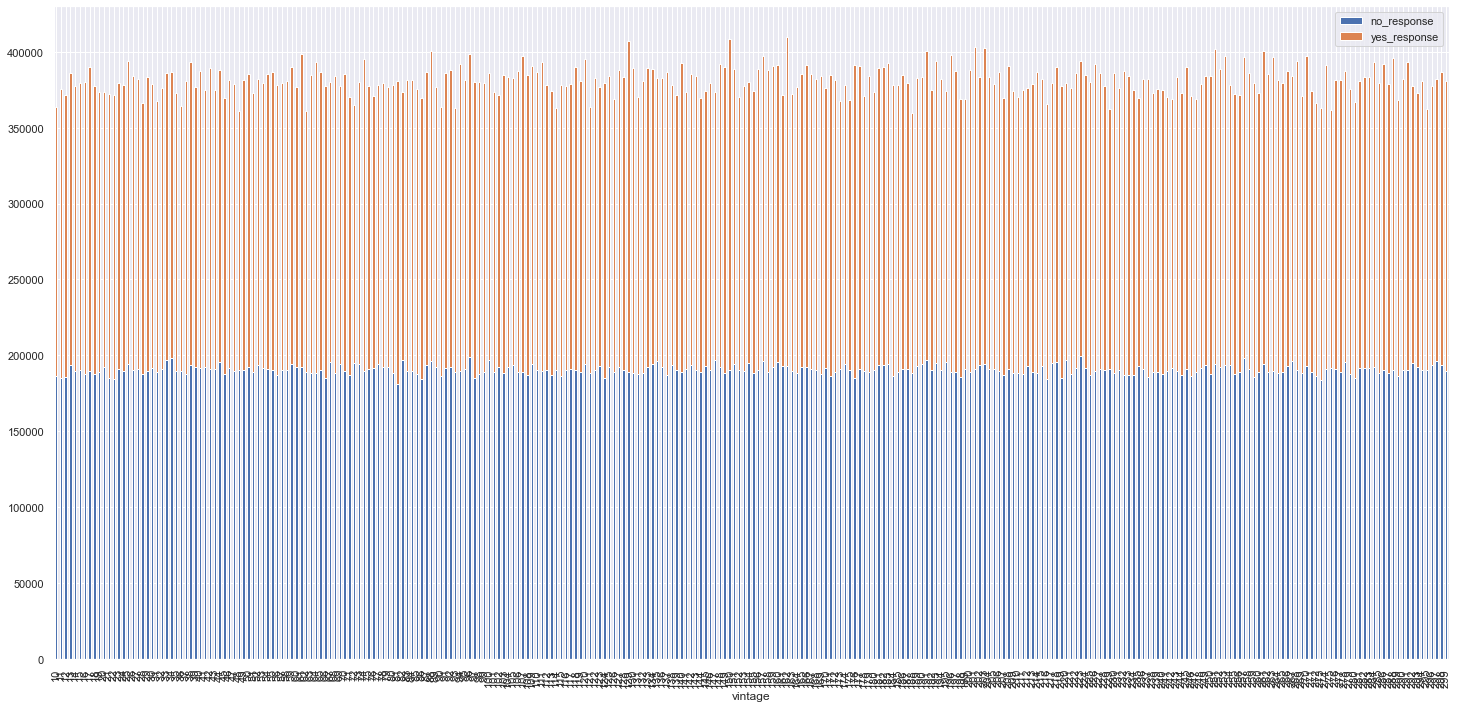

In [49]:
df = pd.pivot_table( index='vintage', columns='response', values='id', data=df4).reset_index()
df.columns = ['vintage', 'no_response', 'yes_response']
df.plot( x='vintage', kind='bar', stacked=True);

### **H8.** Pessoas sem carta de motorista tendem a nao querer o seguro de carro.


**TRUE** Pessoas sem carta de motorista tendem a nao querer o seguro de carro.

C:\Users\leo_m\anaconda3\envs\Health_Insurance\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


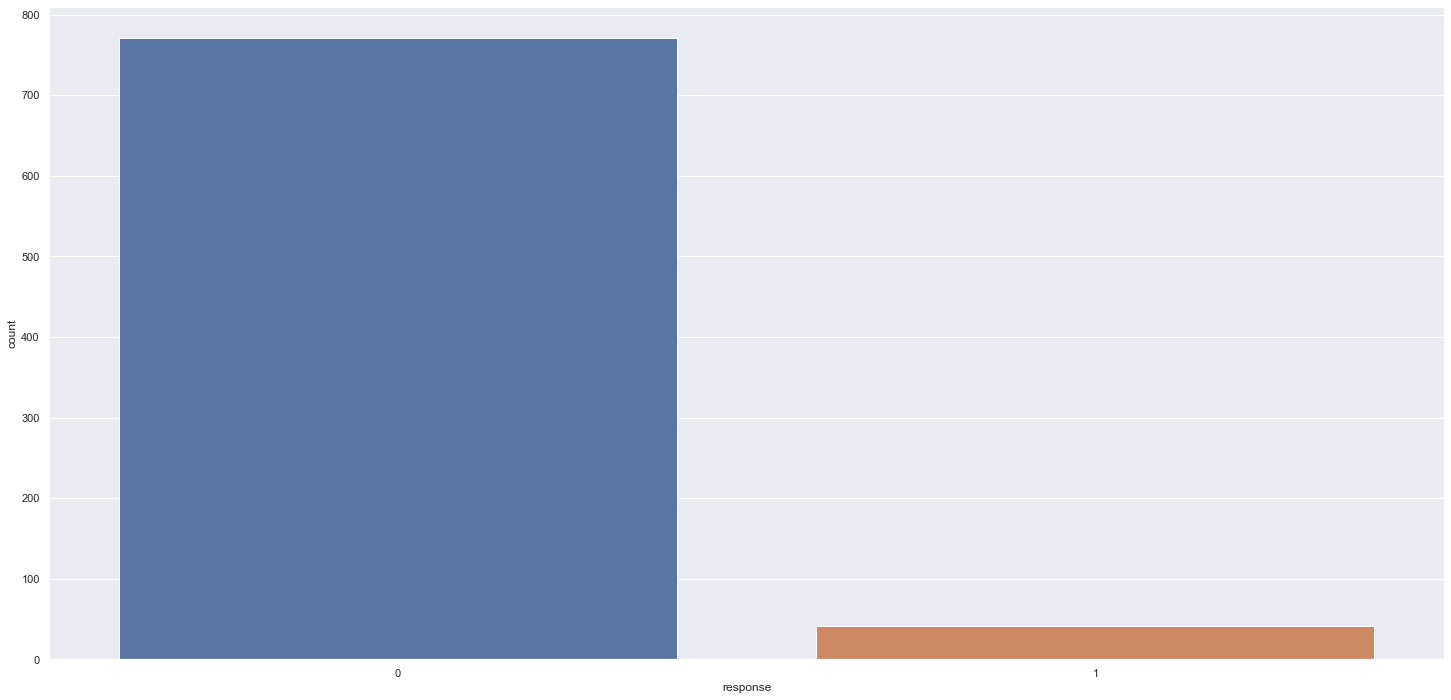

In [50]:
aux = df4.loc[df4['driving_license'] == 0 ]['response']
sns.countplot(aux);

## 4.3 Hypotheses Relevance

In [51]:
tab =[['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1 - Mulheres estão mais propensas a contratar seguros de carro.', 'False', 'Medium'],  
      ['H2 - A Faixa de Meia-idade tem maior a possibilidade de contratar um seguro de carro.', 'True', 'High'],  
      ['H3 - O local de residência influi na decisão de contratar um seguro de carro.', 'True', 'Low'],
      ['H4 - Pessoas que já tiveram danos em seus carros tem maior propensão a contratar um seguro de carro.', 'True', 'High'],
      ['H5 - Pessoas que a já possuem seguro de carro tem maior propensão a adquirir uma nova apólice.', 'False', 'Medium'],
      ['H6 - Pessoas com veículos mais novos tem maior tendência a contratar seguro de carro.', 'False', 'Low'],
      ['H7 - Clientes com relação mais antiga com a seguradora tem maior propensão em contratar um novo produto.', 'False', 'Low'],
      ['H8 - Pessoas sem carta de motorista tendem a nao querer o seguro de carro.', 'True', 'High'],
    ]  

print(tabulate(tab, headers='firstrow', tablefmt = 'fancy_grid'))

╒══════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════╤═════════════╕
│ Hypothesis                                                                                               │ Conclusion   │ Relevance   │
╞══════════════════════════════════════════════════════════════════════════════════════════════════════════╪══════════════╪═════════════╡
│ H1 - Mulheres estão mais propensas a contratar seguros de carro.                                         │ False        │ Medium      │
├──────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────┼─────────────┤
│ H2 - A Faixa de Meia-idade tem maior a possibilidade de contratar um seguro de carro.                    │ True         │ High        │
├──────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────┼─────────────┤
│ H3 - O local de residência influ

## 4.4 Analise Multivariada

### 4.3.1 Numerical Attributes

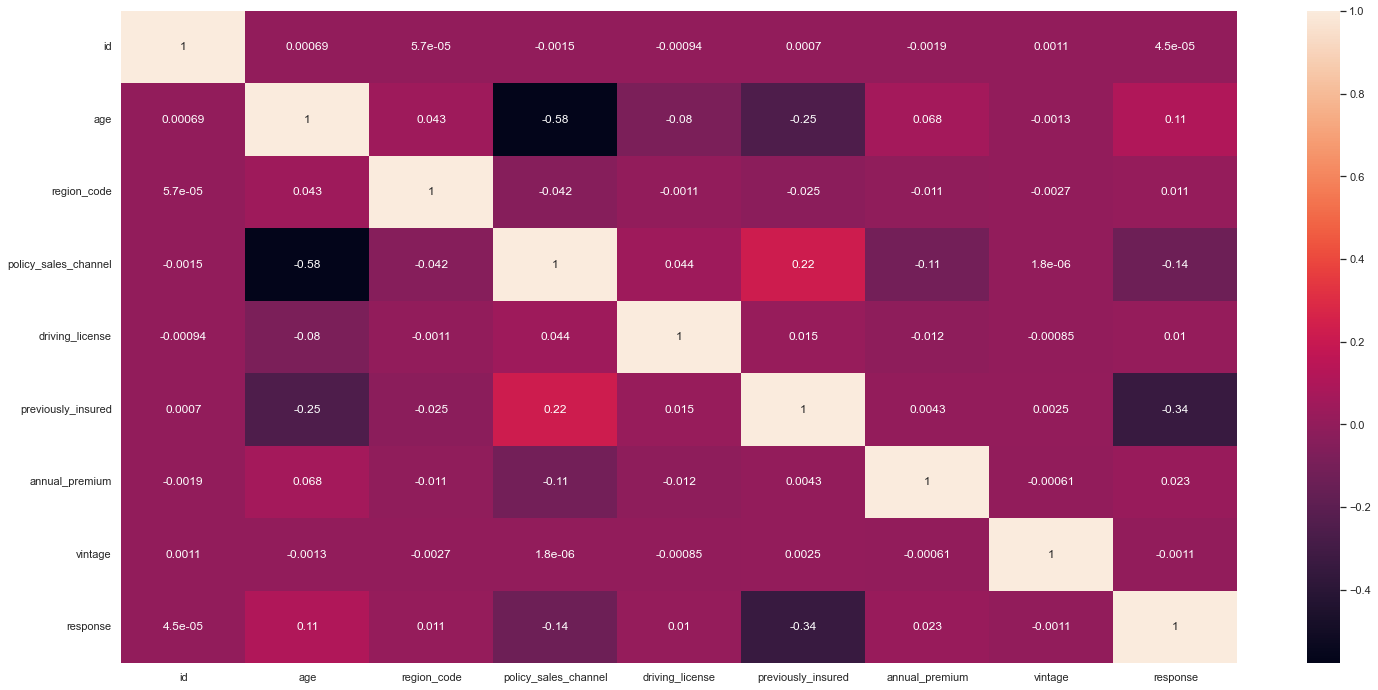

In [52]:
correlation=num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True);

### 4.3.2. Categorical Attributes

<AxesSubplot:>

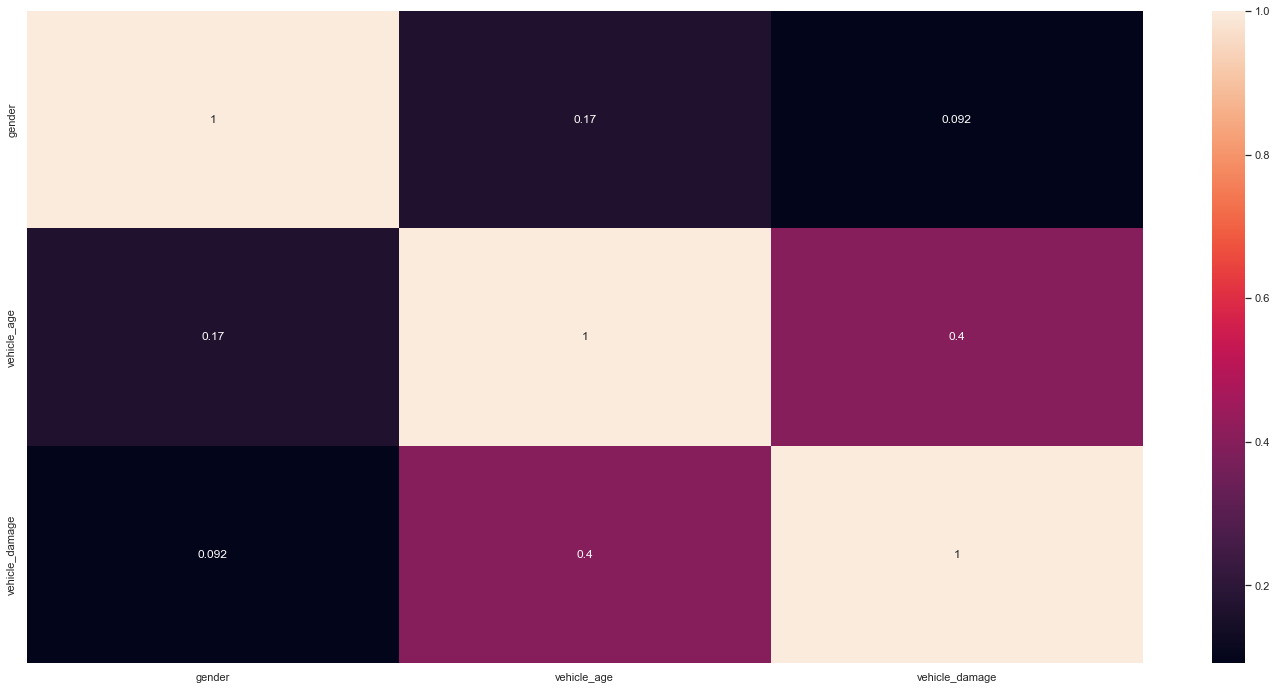

In [53]:
a = cat_attributes

# Calculate cramer V
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )
a3 = cramer_v( a['gender'], a['vehicle_damage'] )

a4 = cramer_v( a['vehicle_age'], a['gender'] )
a5 = cramer_v( a['vehicle_age'], a['vehicle_age'] )
a6 = cramer_v( a['vehicle_age'], a['vehicle_damage'] )

a7 = cramer_v( a['vehicle_damage'], a['gender'] )
a8 = cramer_v( a['vehicle_damage'], a['vehicle_age'] )
a9 = cramer_v( a['vehicle_damage'], a['vehicle_damage'] )

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3], 
                   'vehicle_age': [a4, a5, a6],
                   'vehicle_damage': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0. PASSO 05 - DATA PREPARATION

In [54]:
df5 = df4.copy()

In [55]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis= 1 )

## 5.1. Standardization

In [59]:
ss = StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
#pickle.dump( ss, open( 'C:/Users/leo_m/Repos/health-insurance-by-leofaria/src/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2. Rescaling

In [61]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
#pickle.dump( mms_age, open( 'C:/Users/leo_m/Repos/health-insurance-by-leofaria/src/features/age_scaler.pkl', 'wb' ) )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
#pickle.dump( mms_vintage, open( 'C:/Users/leo_m/Repos/health-insurance-by-leofaria/src/features/vintage_scaler.pkl', 'wb' ) )


## 5.3. Encoder

In [62]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
#pickle.dump( target_encode_gender, open( 'C:/Users/leo_m/Repos/health-insurance-by-leofaria/src/features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
#pickle.dump( target_encode_region_code, open( 'C:/Users/leo_m/Repos/health-insurance-by-leofaria/src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
#pickle.dump( fe_policy_sales_channel, open( 'C:/Users/leo_m/Repos/health-insurance-by-leofaria/src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.4. Validation Preparation

In [63]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0. PASSO 06 -  FEATURE SELECTION

In [64]:
df6=df5.copy()

## 6.1 Boruta Feature Selector

In [162]:
# #retirar minhas variaveis respostas
# x_train_n = df6.drop( ['id', 'response'], axis=1 ).values
# #ravel guarda valores em vetor
# y_train_n = y_train.values.ravel()


# # Define model
# et = en.ExtraTreesClassifier( n_jobs=-1 )
# # n_jobs utiliza todos os nucleos do pc

# # Define boruta
# boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

In [163]:
# #support valor do rank
# cols_selected = boruta.support_.tolist()

# # best features
# x_train_fs = df5.drop( ['id', 'response'], axis=1 )
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
# cols_selected_boruta foi a 'age'

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 6.2. Importância das Features (Se o Boruta Selecionar somente 1 ou 2 features)

In [65]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.272203
0                annual_premium    0.244164
0                           age    0.165347
0                   region_code    0.107612
0                vehicle_damage    0.067949
0          policy_sales_channel    0.057919
0            previously_insured    0.056881
0      vehicle_age_below_1_year    0.014548
0  vehicle_age_between_1_2_year    0.006015
0                        gender    0.004826
0      vehicle_age_over_2_years    0.002029
0               driving_license    0.000508


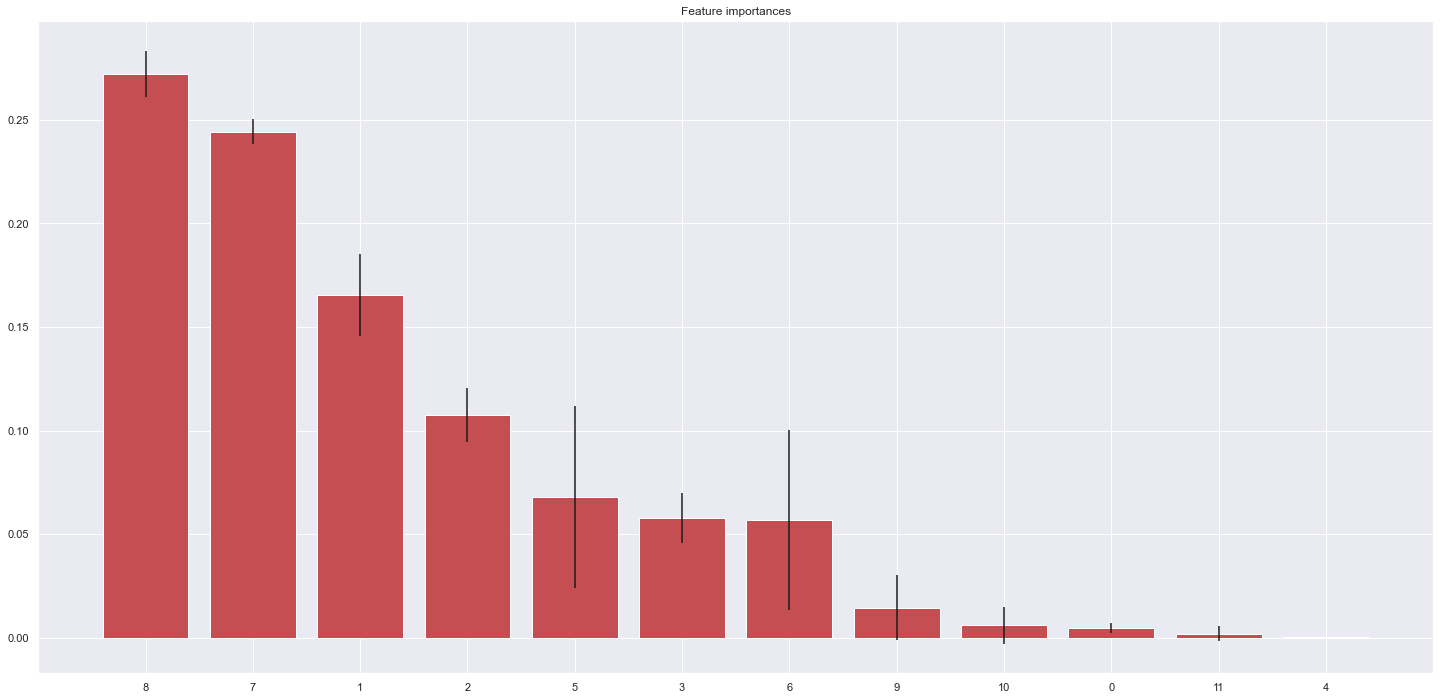

In [66]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. PASSO 07 -  MACHINE LEARNING MODULLING

In [67]:
df7 = df6.copy()

cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']  



#df5 is where my train features are, and only catch my columns selected
# x_train = df5[ cols_selected ]
x_train = df7[ cols_selected ]


# x validation is on 5.4 (validation prep)
x_validation = x_validation[ cols_selected ]

# y_validation its on 5.0 split
Y_vali = y_validation.copy()

model_rank = pd.DataFrame(columns={'Model':[], "Precision_at_k": [], "Recall_at_k": []})

In [68]:
df100 = x_train.copy()

## 7.1. KNN Classifier

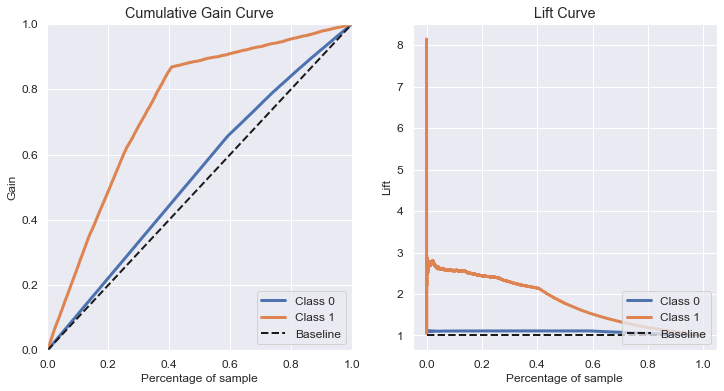

In [69]:
# model definition
model_knn = nh.KNeighborsClassifier( n_neighbors=7 ).fit( x_train, y_train )

# model prediction - generalizacao do modelo e nao o de aprendizado
yhat_proba_knn = model_knn.predict_proba( x_validation )

model_rank_1 = model_results (model_knn, "KNN Classifier", df5, 20000 )

## 7.2. Logistic Regression

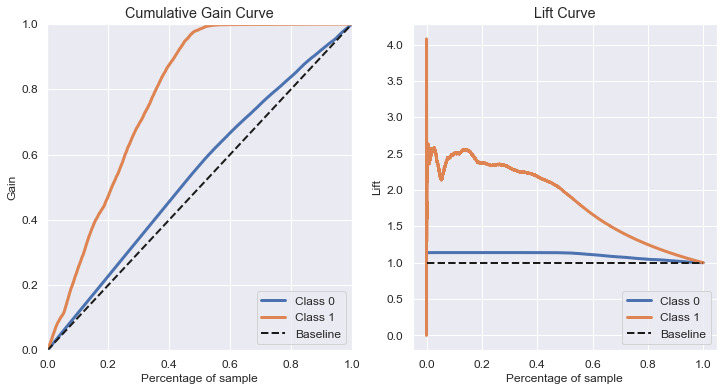

In [70]:
# model definition
model_reglog = LogisticRegression(penalty='l2', solver='newton-cg').fit(x_train,y_train)

# model prediction - generalizacao do modelo e nao o de aprendizado
yhat_proba_reglog = model_reglog.predict_proba(x_validation)

model_rank_2 = model_results (model_reglog, "Logistic Regression Classifier", df7, 20000 )


## 7.3. Extra Trees Classifier

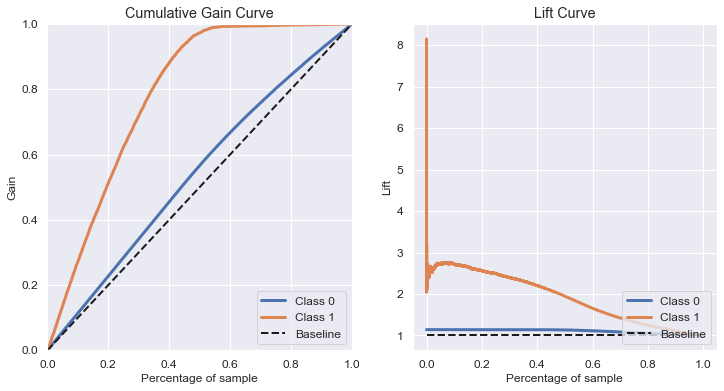

In [71]:
# model definition
model_et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# model prediction
yhat_proba_et = model_et.predict_proba( x_validation )

model_rank_3 = model_results (model_et, "Extra Trees Classifier", df7, 20000 )

## 7.4. Random Forest

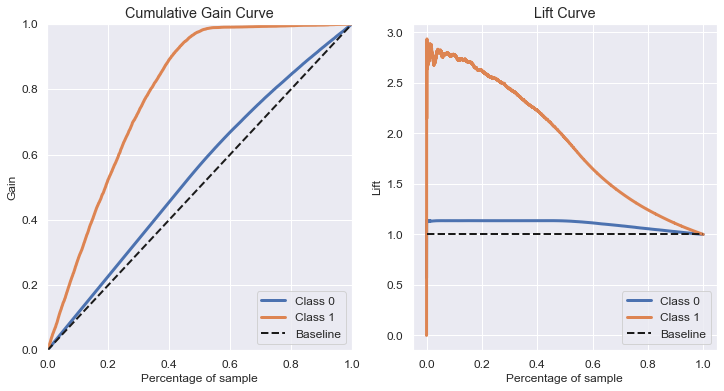

In [72]:
# model definition
model_rf = en.RandomForestClassifier(n_estimators=100,random_state=42).fit(x_train,y_train)

# model prediction
yhat_proba_rf = model_rf.predict(x_validation)

model_rank_4 = model_results (model_rf, "Random Forest Classifier", df7, 20000 )


## 7.5 XGBoost 

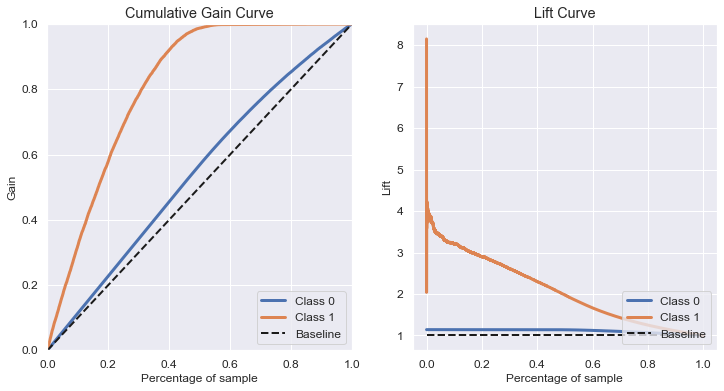

In [73]:
# model definition
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              use_label_encoder=False,
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              n_jobs=-1,
                              subsample=0.7,
                              colsample_bytree=0.9,
                              verbosity=0).fit(x_train,y_train)

# model prediction
yhat_proba_xgb = model_xgb.predict_proba(x_validation)

model_rank_5 = model_results (model_xgb, "XGBoost Classifier", df7, 20000 )

## 7.6 Naive Bayes Classifier model

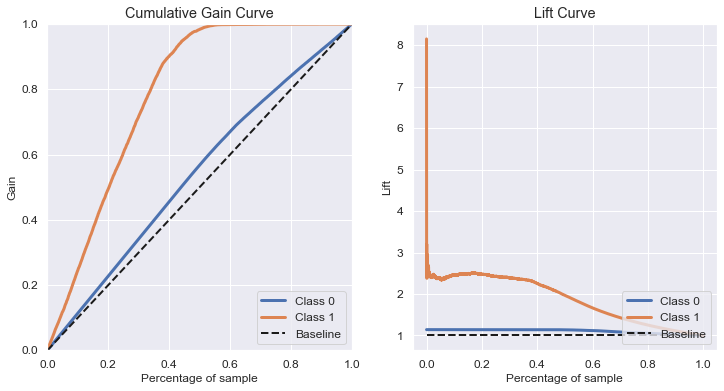

In [74]:
# model definition
model_nbc = GaussianNB().fit(x_train,y_train)


# model prediction
yhat_proba_xgb = model_nbc.predict_proba(x_validation)


model_rank_6 = model_results (model_nbc, "Naive Bayes Classifier", df7, 20000 )

## 7.7 Light Gradient Boosting Machine Classifier model

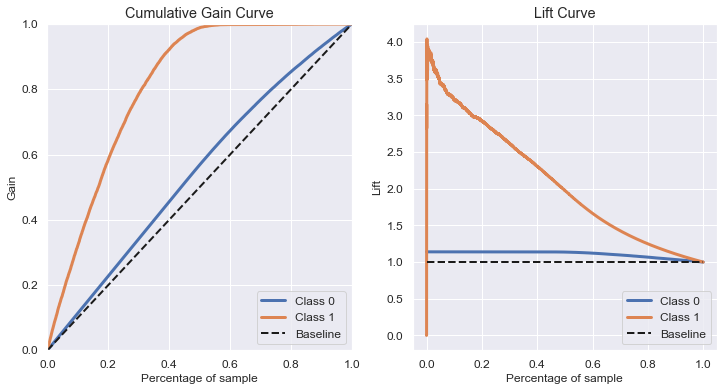

In [75]:
# model definition
model_lgbm = LGBMClassifier().fit(x_train,y_train)

# model prediction
yhat_proba_lgbm = model_lgbm.predict_proba(x_validation)

model_rank_7 = model_results (model_lgbm, "LGBM Classifier", df7, 20000 )

## 7.8 Compare Model's Performance

### 7.9.1. Single Performance

In [182]:
res_total = pd.concat([model_rank_1, model_rank_2, model_rank_3, model_rank_4, model_rank_5, model_rank_6, model_rank_7], axis=0)
res_total.sort_values('Recall_at_k', ascending = False).reset_index(drop=True)

,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.333933,0.707671
1,XGBoost Classifier,0.333433,0.706612
2,Random Forest Classifier,0.306385,0.649290
3,Extra Trees Classifier,0.302985,0.642085
4,Naive Bayes Classifier,0.296485,0.628311
5,KNN Classifier,0.295685,0.626616
6,Logistic Regression Classifier,0.289486,0.613477


### 7.9.2. Real Performance - Cross Validation

In [76]:
models_performance_cv = pd.DataFrame({'Model':[], 'Precision_at_k': [], 'Recall_at_k': []}) 

models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'KNN CV', model_knn, x_train, y_train, 20000)
models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'LR CV',  model_reglog, x_train, y_train, 20000) 
models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'ET CV',  model_et, x_train, y_train, 20000) 
models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'RF CV',  model_rf, x_train, y_train, 20000) 
models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'XGB CV', model_xgb, x_train, y_train, 20000) 
models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'NBC CV', model_nbc, x_train, y_train, 20000) 
models_performance_cv  = cross_validation (df7, models_performance_cv, 5, 'LGBM CV', model_lgbm, x_train, y_train, 20000) 


models_performance_cv = models_performance_cv.sort_values('Precision_at_k', ascending = False).reset_index(drop=True)
#pickle.dump( models_performance_cv, open( 'C:/Users/leo_m/Repos/health_insurance_by_leofaria/cv/cross_validation.pkl', 'wb' ) )

C:\Users\leo_m\AppData\Local\Temp/ipykernel_7240/2309468703.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
C:\Users\leo_m\AppData\Local\Temp/ipykernel_7240/2309468703.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
C:\Users\leo_m\AppData\Local\Temp/ipykernel_7240/2309468703.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

C:\Users\leo_m\AppData\Local\Temp/ipykernel_7240/2309468703.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
C:\Users\leo_m\AppData\Local\Temp/ipykernel_7240/2309468703.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
C:\Users\leo_m\AppData\Local\Temp/ipykernel_7240/2309468703.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [78]:
models_performance_cv = pickle.load( open( 'C:/Users/leo_m/Repos/health_insurance_by_leofaria/cv/cross_validation.pkl', 'rb' ) )

models_performance_cv

,Model,Precision_at_k,Recall_at_k
0,LGBM CV,0.311 +/- 0.001,0.83 +/- 0.002
1,XGB CV,0.309 +/- 0.001,0.827 +/- 0.002
2,RF CV,0.293 +/- 0.002,0.783 +/- 0.005
3,NBC CV,0.291 +/- 0.001,0.776 +/- 0.003
4,ET CV,0.29 +/- 0.002,0.774 +/- 0.005
5,KNN CV,0.285 +/- 0.002,0.762 +/- 0.005
6,LR CV,0.277 +/- 0.002,0.74 +/- 0.006


# 8.0. HYPERPARAMETER FINE TUNING

In [84]:
df8 = df7.copy()

## 8.1 XGB TUNING

In [ ]:
# param = {'n_estimators':[2000, 2500, 3000, 3500],
#          'eta':[0.01, 0.03],
#          'gamma':[3, 10, 20],
#          'max_depth':[3, 5, 9],
#          'subsample':[0.1, 0.5, 0.7],
#          'colsample_bytree':[0.3, 0.7, 0.9],
#          'min_child_weight':[3, 8, 15],
#         }

# MAX_EVAL = 5

# # final_result = pd.DataFrame()
# hyperparam_lst = []

# for i in range(MAX_EVAL):
#     #randomly selected hyperparameters
#     hp = {k:rd.sample(v, 1)[0] for k, v in param.items()}
#     #print the selected ones
#     print(hp)
    
#     #model
#     model_xgb = xgb.XGBClassifier(objective='binary:logistic',
#                                   use_label_encoder=False,
#                                   n_estimators=hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   gamma=hp['gamma'],
#                                   max_depth=hp['max_depth'],
#                                   n_jobs=-1,
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'],
#                                   verbosity=0)
    
#     result = cross_validation (df7, final_result, 5, 'XGB Classifier', model_xgb, x_train, y_train, 20000) 
#     iter_nr = pd.Series([i], name='Iter_nr')
#     result_w_nr = pd.concat([result, iter_nr], axis=1)
#     final_result = pd.concat([final_result, result_w_nr], ignore_index=True)




# final_result.sort_values('Recall_at_k', ascending = False).reset_index(drop=True)
# final_result

# pickle.dump( final_result, open( 'C:/Users/leo_m/Repos/health_insurance_by_leofaria/cv/xgb_tuning.pkl', 'wb' ) )

## 8.2 LGBM TUNING 

In [ ]:
lgbm_parameter = {'num_leaves': (5,15,45,60,90),
                  'max_depth': (5, 7, 10 ),
                  'min_split_gain': (0.001, 0.01 ,0.1),          
                  'subsample':(0.5, 1),
                  'colsample_bytree':(0.1, 1)
                 }

MAX_EVAL = 5


for i in range(MAX_EVAL):
    #randomly selected hyperparameters
    hp = {k:rd.sample(v, 1)[0] for k, v in lgbm_parameter.items()}
    #print the selected ones
    print(hp)
    #model
    model_lgbm=LGBMClassifier(  objective = 'binary',
                                num_leaves=hp['num_leaves'],
                                max_depth=hp['max_depth'],
                                min_split_gain=hp['min_split_gain'],
                                subsample=hp['subsample'],
                                colsample_bytree=hp['colsample_bytree'])
    
    result = cross_validation (df7, final_result_lg, 5, 'LGBM Classifier', model_lgbm, x_train, y_train, 20000) 
    iter_nr = pd.Series([i], name='Iter_nr')
    result_w_nr = pd.concat([result, iter_nr], axis=1)
    final_result_lg = pd.concat([final_result_lg, result_w_nr], ignore_index=True)


final_result_lg.sort_values('Recall_at_k', ascending = False).reset_index(drop=True)
final_result_lg

pickle.dump( final_result_lgbm, open( 'C:/Users/leo_m/Repos/health_insurance_by_leofaria/cv/lgbm_tuning_10.pkl', 'wb' ) )


In [ ]:
# como colocar os param em lista
#param_tuned = 'num_leaves': 60, 'max_depth': 10, 'min_split_gain': 0.001, 'subsample': 0.5, 'colsample_bytree': 1

final_result_lgbm = pickle.load( open( 'C:/Users/leo_m/Repos/health_insurance_by_leofaria/cv/lgbm_tuning_10.pkl', 'rb' ) )

final_result_lgbm

In [79]:
final_result_lgbm = pickle.load( open( 'C:/Users/leo_m/Repos/health_insurance_by_leofaria/cv/lgbm_tuning_1.pkl', 'rb' ) )

final_result_lgbm

,Model,Precision_at_k,Recall_at_k,Iter_nr
0,LGBM Classifier,0.305 +/- 0.0,0.814 +/- 0.0,0
1,LGBM Classifier,0.305 +/- 0.0,0.814 +/- 0.001,1
2,LGBM Classifier,0.311 +/- 0.0,0.832 +/- 0.002,2
3,LGBM Classifier,0.305 +/- 0.0,0.814 +/- 0.001,3
4,LGBM Classifier,0.311 +/- 0.001,0.83 +/- 0.002,4


## 8.3 Final Model

In [ ]:
#model
model_lgbm_tuned=LGBMClassifier(  objective = 'binary',
                                num_leaves=60,
                                max_depth=10,
                                min_split_gain=0.001,
                                subsample=0.5,
                                colsample_bytree=1).fit(x_train,y_train)

lgbm_tuned_20k = model_results (model_lgbm_tuned, "LGBM Classifier", df7, 20000 )

# model prediction
yhat_lgbm_tuned = model_lgbm.predict_proba(x_validation)


lgbm_tuned_20k


C:\Users\leo_m\anaconda3\envs\Health_Insurance\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.232944,0.997004


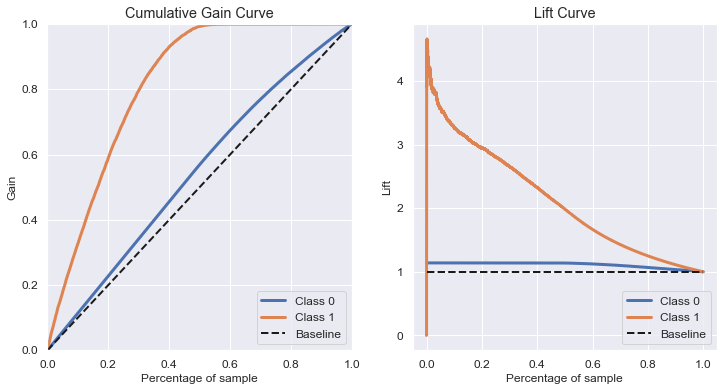

In [81]:
model_lgbm_tuned = pickle.load( open( 'C:/Users/leo_m/Repos/health_insurance_by_leofaria/cv/lgbm_tuned.pkl', 'rb' ) )
lgbm_tuned_40k = model_results (model_lgbm_tuned, "LGBM Classifier", df7,40000 )

lgbm_tuned_40k

,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.323469,0.806976


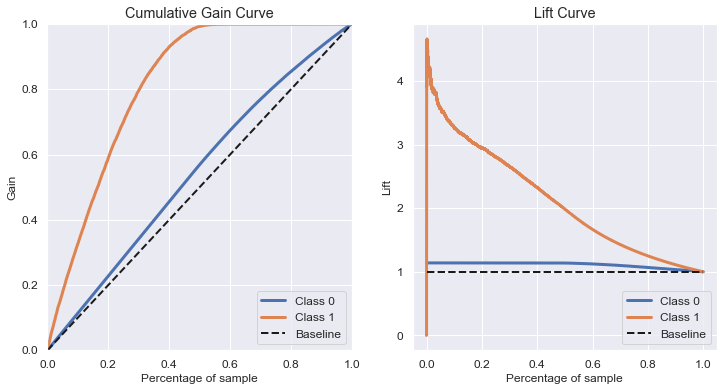

In [82]:
xgb_tuned_call80 = model_results (model_lgbm_tuned, "LGBM Classifier", df7,23315 )
xgb_tuned_call80

# 9.0. PASSO 09 -  Model Performance

In [85]:
df9 = df8.copy

In [ ]:
# copy dataframe
df9 = x_validation.copy()
df9['response'] = y_validation.copy()

# propensity score 1D
df9['score'] = yhat_lgbm_tuned[:, 1].tolist()


# sort clients by propensity score
df9 = df9.sort_values( 'score', ascending=False ).reset_index(drop=True)

# Rank
df9['ranking'] = df9.index+1

In [ ]:
df9.head()

# 10.0. PASSO 10 -  Deploy to Production

## 10.1. Health Insurance Class

In [ ]:
import pickle
import numpy  as np
import pandas as pd


class HealthInsurance (object):
    
    def __init__(self):
        self.home_path                   = 'C:/Users/leo_m/Repos/health_insurance_by_leofaria/src'
        self.age_scaler                  = pickle.load(open(self.home_path + 'features/age_scaler.pkl'))
        self.annual_premium_scaler       = pickle.load(open(self.home_path + 'features/annual_premium_scaler.pkl'))        
        self.policy_sales_channel_scaler = pickle.load(open(self.home_path + 'features/policy_sales_channel_scaler.pkl'))        
        self.region_code_scaler          = pickle.load(open(self.home_path + 'features/region_code_scaler.pkl'))        
        self.vintage_scaler              = pickle.load(open(self.home_path + 'features/vintage_scaler.pkl'))  
     
    
    def data_cleaning (self, df1):
        df1.rename(columns={'Unnamed: 0': 'id'}, inplace=True)    
        
        return df1
    
    
    def feature_engineerig(self, df2):
        df2 ['vehicle_damage'] = df2['vehicle_damage'].apply (lambda x : 1 if x == 'Yes' else 0 ).astype(int64)
        df2 ['vehicle_age'] = df2 ['vehicle_age'].apply (lambda x: 'less_1_year'   if x == '< 1 Year'  else  'btw_1_2_years'    if x == '1-2 Year'    else 'over_2_years') 
        
        return df2
    
    
    def data_preparation(self, df5):
        # annual_premium
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        # age
        df5['age'] = self.age_scaler.transform(df5[['age']].values)

        # Vintage
        df5['vintage']=self.vintage_scaler.fit_transform(df5[['vintage']].values)

        # gender
        df5=pd.get_dummies(df5,prefix=['gender'],columns=['gender'])

        # region code
        df5['region_code'] = df5['region_code'].map(self.region_code_scaler)

        #policy_sales_channel
        df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(self.policy_sales_channel_scaler)

        # vehicle_age
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )
        
        # feature selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']  
        
        return df5[cols_selected]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['score'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler


In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# loading model
path = 'C:/Users/leo_m/Repos/health_insurance_by_leofaria'
model = pickle.load( open( path + 'cv/lgbm_tuned.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/healthInsurance/getScore', methods=['POST'] )
def healthInsurance_getScore():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Health Insurance class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 10.3. API Tester


In [76]:
# loading test dataset
df_test = x_validation
df_test['response'] = y_validation

In [77]:
df_test = df_test.sample(10)

In [78]:
df_test
#.to_csv('C:/Users/leo_m/Repos/health_insurance_by_leofaria/datasets/googlesheet.csv', index=False)

In [79]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [80]:
data

'[{"id": 227621, "gender": "Female", "age": 22, "region_code": 35.0, "policy_sales_channel": 152.0, "driving_license": 1, "vehicle_age": "below_1_year", "vehicle_damage": 0, "previously_insured": 1, "annual_premium": 34653.0, "vintage": 185, "response": 0}, {"id": 268841, "gender": "Male", "age": 38, "region_code": 26.0, "policy_sales_channel": 124.0, "driving_license": 1, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "previously_insured": 0, "annual_premium": 2630.0, "vintage": 42, "response": 0}, {"id": 353782, "gender": "Female", "age": 45, "region_code": 30.0, "policy_sales_channel": 122.0, "driving_license": 1, "vehicle_age": "between_1_2_year", "vehicle_damage": 0, "previously_insured": 1, "annual_premium": 22751.0, "vintage": 138, "response": 0}, {"id": 324312, "gender": "Female", "age": 26, "region_code": 8.0, "policy_sales_channel": 152.0, "driving_license": 1, "vehicle_age": "below_1_year", "vehicle_damage": 0, "previously_insured": 1, "annual_premium": 36674.0, "vi

In [83]:
# API Call
#url = 'http://127.0.0.1:5000/predict'
url = 'https://health-insurance-by-leofaria.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [82]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

,annual_premium,vintage,age,region_code,vehicle_damage,previously_insured,policy_sales_channel,score
1,-1.887715e-17,0.110727,0.276923,NaN,0,1,None,0.001907
5,-1.887715e-17,0.463668,0.400000,0.072422,0,1,None,0.000441
2,1.000000e+00,0.442907,0.384615,NaN,0,1,None,0.000398
4,-1.887715e-17,0.761246,0.215385,NaN,0,1,None,0.000161
8,-1.887715e-17,0.567474,0.430769,NaN,0,1,None,0.000074
